In [29]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import quantity_support

from astropy import units as u
from astropy.io import fits
from astropy.table import QTable
import seaborn as sns

import scipy.stats

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from astropy import constants as const
from astropy.cosmology import z_at_value
from astropy.cosmology import Planck15 as cosmo

#plt.style.use('classic')

In [30]:
deli='./deliverables/'
orig='./originals/'
play='./playground/'

In [31]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 18
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 16

path_fig='./plots/'

In [32]:
!cp ../XSAF/08_PhysicalParameters/deliverables/results_cut.fits ./originals/results_cut.fits

In [33]:
with fits.open(orig+'/results_cut.fits', memmap=True) as hdul:
    #hdul.info()
    xsaf = QTable(hdul[1].data)

In [34]:
len(xsaf[xsaf['logMbh_best']>0])

105

In [35]:
#xsaf=xsaf[xsaf['logMbh_best']>0]

In [36]:
def flux2lum(f,z):
    dist= cosmo.luminosity_distance(z)
    lum = f*dist**2*4*np.pi
    return lum.to(u.erg/u.s)

def Mdot(Lbol,Mbh):
    crit=3E-2
    eta=0.1
    Ledd=1.3E38*Mbh.to(u.Msun).value * u.erg/u.s
    lamEdd=Lbol/Ledd
    if lamEdd>crit:
        Md=Lbol/(eta*const.c**2)
    elif lamEdd<=crit:
        Md=Lbol**(1/2)*Ledd**(1/2)/(eta*const.c**2)
    elif np.isnan(lamEdd)==True:
        Md=np.nan*u.Msun/u.yr
    return Md.to(u.Msun/u.yr)

def enssfr(ssfr,z):
    ssfr=ssfr
    en=ssfr-0.3*z+9.62
    return en

#AGN
MBH=        10**xsaf['logMbh_best']*u.Msun
LAGN=       (xsaf['bayes.agn.accretion_power']*u.W).to(u.erg/u.s)
LX =         flux2lum(xsaf['HFlux']*u.erg/u.s/u.cm**2,xsaf['Z_Spec'])
EDD=         LAGN.value/(1.3E38*MBH.value)
BHAR=np.array([])
for i in range(len(MBH.value)):
    BHAR=np.append(BHAR,Mdot(LAGN[i],MBH[i]).value)
BHAR=       BHAR                         *u.Msun/u.yr

#Host
MST =       xsaf['bayes.stellar.m_star'] *u.Msun
Z=          xsaf['best.universe.redshift']
SFR=        xsaf['bayes.sfh.sfr']        *u.Msun/u.yr
ssfr=       np.log10((SFR/MST).value)
ENSSFR=     enssfr(ssfr,Z)

sBHAR=(25*LX.value)/(1.3E38*0.002*MST.value)
#sBHAR=np.log10((LAGN.value)/(1.3E38*0.002*MST.value))


#Starforming=enssfr>-1.2
#Quiescent=enssfr<-1.2

/home/ivan/Softwares/miniconda3/envs/astroutils/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


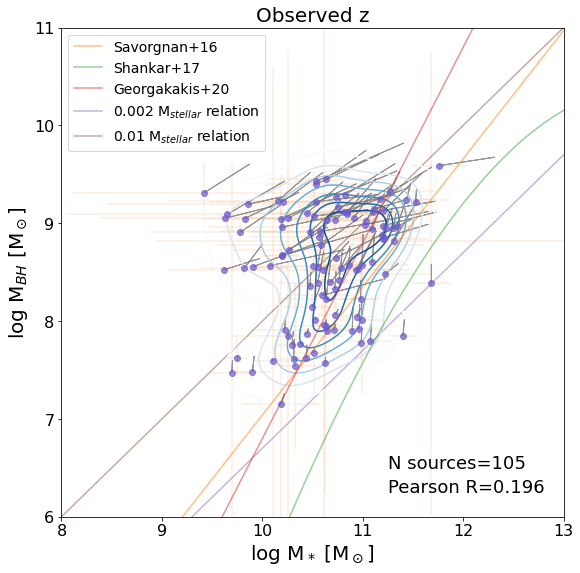

In [37]:
def bh_savorgnan(ste_mass):
    logbh = 8.35+1.31*(ste_mass-11)
    return logbh

def bh_unbias_shankar(ste_mass):
    logbh = 7.574+1.946*(ste_mass-11)-0.306*(ste_mass-11)**2-0.011*(ste_mass-11)**3
    return logbh

def bh_georgakakis(ste_mass):
    logbh = 6.8+2*(ste_mass-10)
    return logbh

xmin,xmax,ymin,ymax=8,13,6,11
fig, ax = plt.subplots(ncols=1, figsize=(9, 9))
with_mbh=~np.isnan(MBH.value)

ax.set_title('Observed z',size=20)

toplot_x, toplot_y=np.log10(MST[with_mbh].value), np.log10(MBH[with_mbh].value)
x_err=xsaf['bayes.stellar.m_star_err'][with_mbh]/MST[with_mbh].value
y_err =xsaf['logMbh_err'][with_mbh]

ax.scatter(toplot_x, toplot_y, c='slateblue', alpha=0.7, zorder=3)
sns.kdeplot(toplot_x+1-1, toplot_y+1-1, ax=ax, cmap="Blues", alpha=1, levels=8, thresh=.1)#,cbar=True)
ax.errorbar(toplot_x, toplot_y, xerr=x_err, yerr=y_err, fmt='.', barsabove=True, color='white', ecolor='sandybrown',alpha=0.2, zorder=1)

for i in range(len(toplot_x)):
    ax.arrow(toplot_x[i], toplot_y[i], dx=((SFR[with_mbh][i]*10E7*u.yr)/MST[with_mbh][i]).value, dy=((BHAR[with_mbh][i]*10E7*u.yr)/MBH[with_mbh][i]).value,color='grey',alpha=0.8)

ax.plot(np.arange(xmin,xmax+1),bh_savorgnan(np.arange(xmin,xmax+1)), alpha=0.5,label='Savorgnan+16')
ax.plot(np.arange(xmin,xmax+1,0.1),bh_unbias_shankar(np.arange(xmin,xmax+1,0.1)), alpha=0.5,label='Shankar+17')
ax.plot(np.arange(xmin,xmax+1),bh_georgakakis(np.arange(xmin,xmax+1)), alpha=0.5,label='Georgakakis+20')
ax.plot(np.arange(xmin,xmax+1),np.arange(xmin,xmax+1)-3.3, alpha=0.5, label=r'0.002 M$_{stellar}$ relation',zorder=1)
ax.plot(np.arange(xmin,xmax+1),np.arange(xmin,xmax+1)-2, alpha=0.5, label=r'0.01 M$_{stellar}$ relation',zorder=1)
ax.legend(loc='upper left',fontsize=14)

result = scipy.stats.linregress(toplot_x,toplot_y)
ax.annotate('N sources='+str(len(toplot_x)), xy=(0.65, 0.10), xycoords='axes fraction', fontsize=18)
ax.annotate('Pearson R='+str(result.rvalue.round(3)), xy=(0.65, 0.05), xycoords='axes fraction', fontsize=18)

ax.set_xlabel(r'log M$_*$ [M$_\odot$]',size=20)
ax.set_ylabel(r'log M$_{BH}$ [M$_\odot$]',size=20)
ax.axis([xmin, xmax, ymin, ymax])

plt.savefig(path_fig+'M-M_PCA.png', dpi=150, transparent=False, bbox_inches='tight')
plt.show()

In [38]:
#Histograms

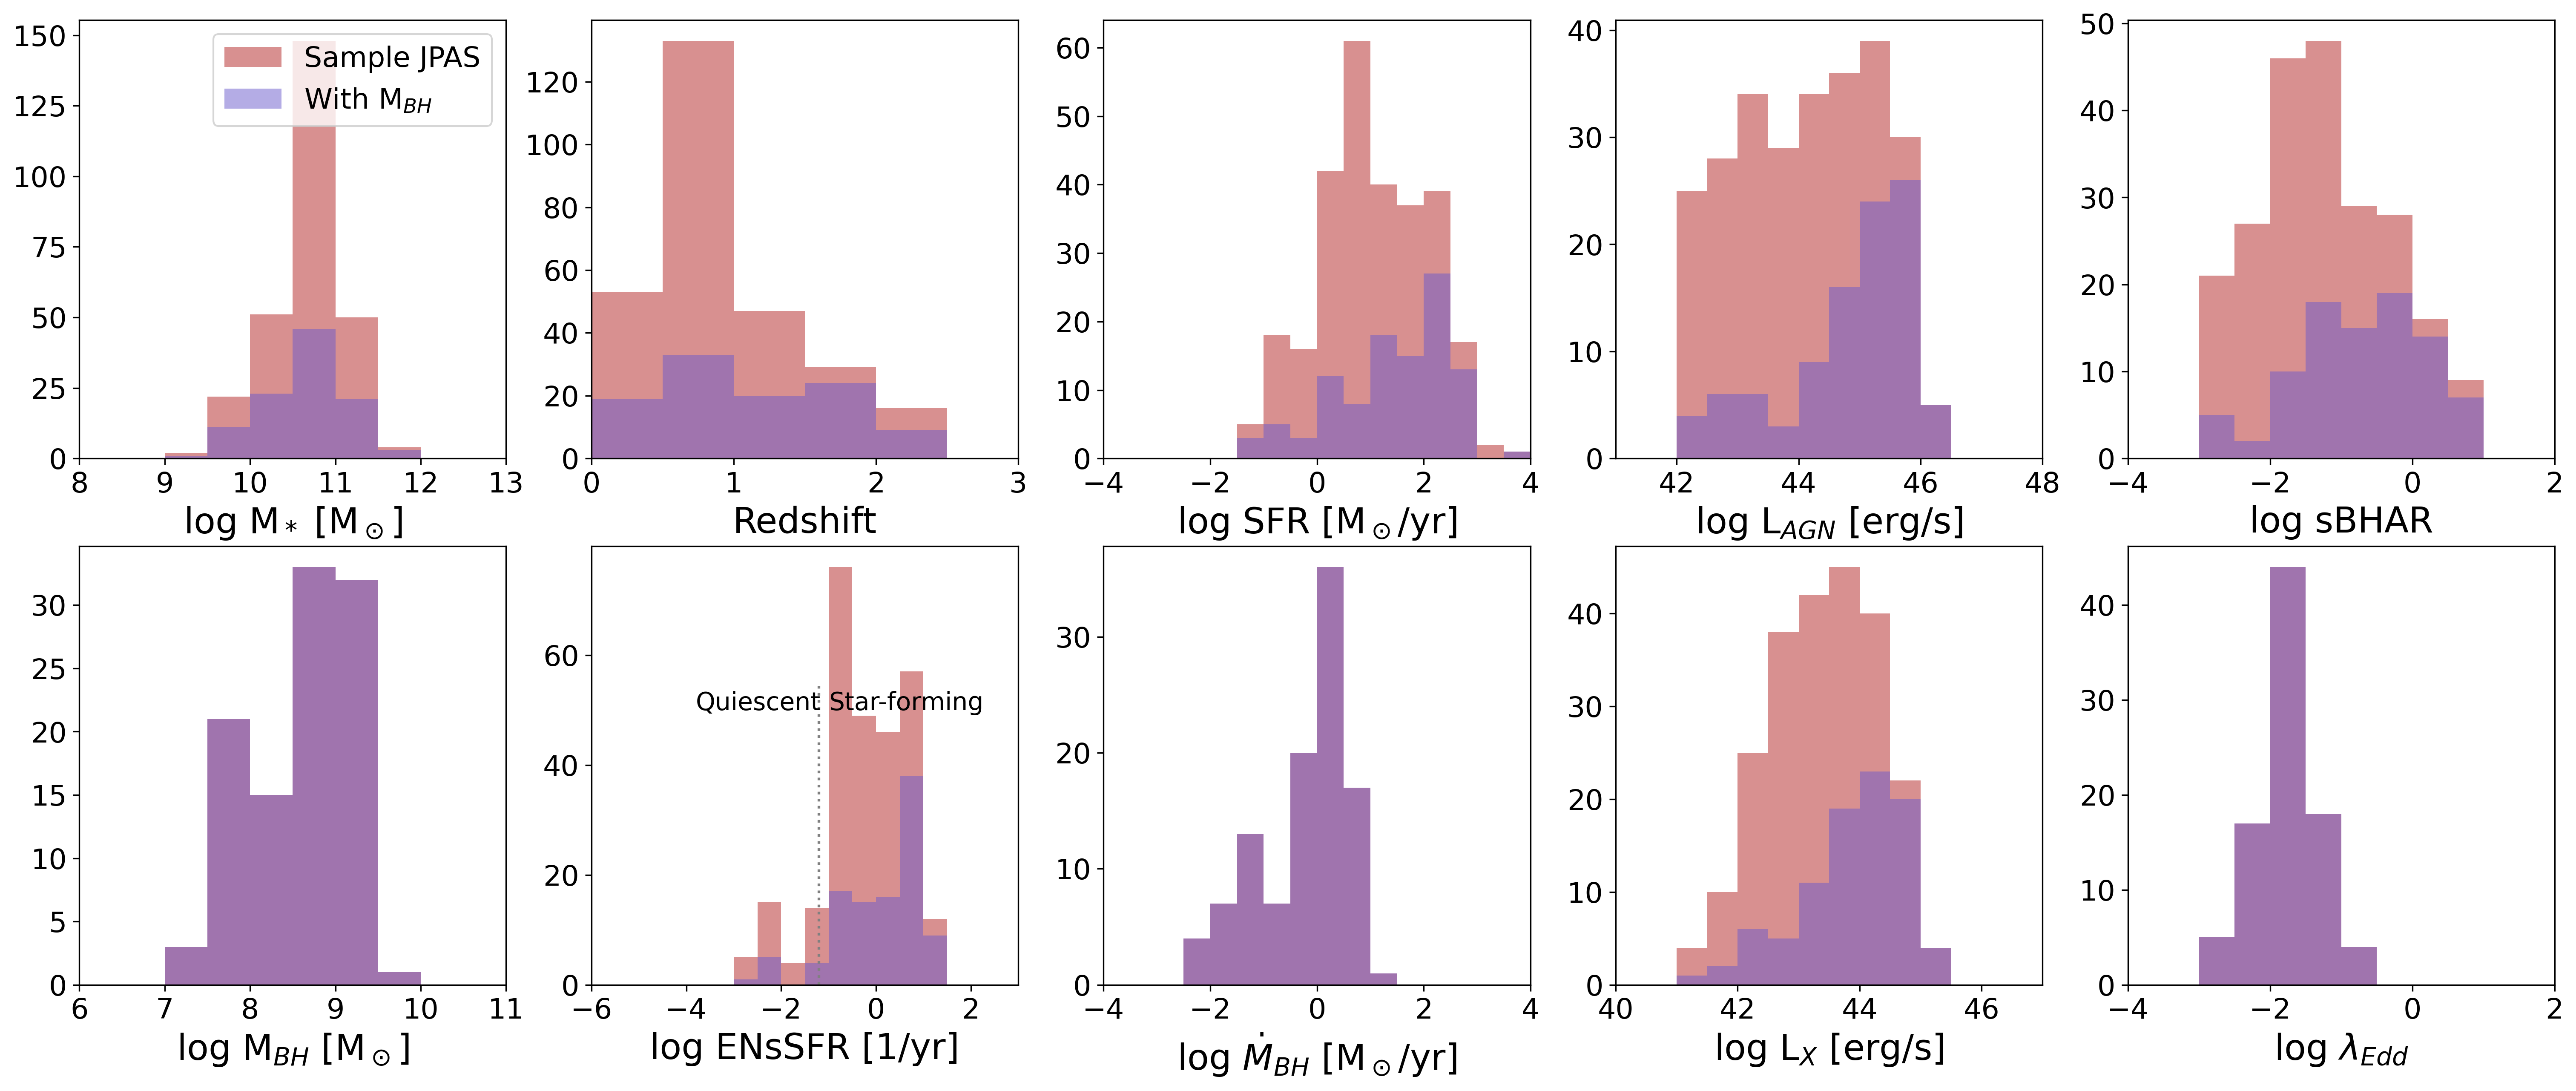

In [39]:
#sns.set_style("white")
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(25, 10), dpi=300)

#M*
ax = axs[0,0]
xmin,xmax=8,13
plot_x=np.log10(MST.value)
with_mbh=~np.isnan(MBH.value)
ax.hist(plot_x,bins=np.arange(xmin+1,xmax+1,0.5), color='firebrick', alpha=0.5, zorder=1, label='Sample JPAS')
ax.hist(plot_x[with_mbh],bins=np.arange(xmin+1,xmax+1,0.5), color='slateblue', alpha=0.5, zorder=1, label=r'With M$_{BH}$')
ax.legend()
ax.axis(xmin=xmin, xmax=xmax)
ax.set_xlabel(r'log M$_*$ [M$_\odot$]',size=20)
#######

#MBH
ax = axs[1,0]
plot_x=np.log10(MBH.value)
xmin,xmax=6,11
ax.hist(plot_x,bins=np.arange(xmin+1,xmax+1,0.5), color='firebrick', alpha=0.5, zorder=1, label=r'With M$_{BH}$')
ax.hist(plot_x[with_mbh],bins=np.arange(xmin+1,xmax+1,0.5), color='slateblue', alpha=0.5, zorder=1, label=r'With M$_{BH}$')
ax.axis(xmin=xmin, xmax=xmax)
ax.set_xlabel(r'log M$_{BH}$ [M$_\odot$]',size=20)
#######

#Z
ax = axs[0,1]
plot_x=Z
xmin,xmax=-1,3
ax.hist(plot_x,bins=np.arange(xmin+1,xmax+1,0.5), color='firebrick', alpha=0.5, zorder=1, label='JPAS-Sample')
ax.hist(plot_x[with_mbh],bins=np.arange(xmin+1,xmax+1,0.5), color='slateblue', alpha=0.5, zorder=1, label=r'With M$_{BH}$')
ax.axis(xmin=xmin+1, xmax=xmax)
ax.set_xlabel(r'Redshift',size=20)
#######

#ENsSFR
ax = axs[1,1]
plot_x=ENSSFR
xmin,xmax=-6,3
ax.hist(plot_x,bins=np.arange(xmin+1,xmax+1,0.5), color='firebrick', alpha=0.5, zorder=1, label='JPAS-Sample')
ax.hist(plot_x[with_mbh],bins=np.arange(xmin+1,xmax+1,0.5), color='slateblue', alpha=0.5, zorder=1, label=r'With M$_{BH}$')
ax.vlines(-1.2,0,55,colors='grey',linestyles='dotted')
ax.annotate('Quiescent', xy=(-3.8, 50), fontsize=14)
ax.annotate('Star-forming', xy=(-1, 50), fontsize=14)
ax.axis(xmin=xmin, xmax=xmax)
ax.set_xlabel(r'log ENsSFR [1/yr]',size=20)
#######

#SFR
ax = axs[0,2]
plot_x=np.log10(SFR.value)
xmin,xmax=-4,4
ax.hist(plot_x,bins=np.arange(xmin+1,xmax+1,0.5), color='firebrick', alpha=0.5, zorder=1, label='JPAS-Sample')
ax.hist(plot_x[with_mbh],bins=np.arange(xmin+1,xmax+1,0.5), color='slateblue', alpha=0.5, zorder=1, label=r'With M$_{BH}$')
ax.axis(xmin=xmin, xmax=xmax)
ax.set_xlabel(r'log SFR [M$_\odot$/yr]',size=20)
#######

#MBHdot
ax = axs[1,2]
plot_x=np.log10(BHAR.value)
xmin,xmax=-4,4
ax.hist(plot_x,bins=np.arange(xmin+1,xmax+1,0.5), color='firebrick', alpha=0.5, zorder=1, label='JPAS-Sample')
ax.hist(plot_x[with_mbh],bins=np.arange(xmin+1,xmax+1,0.5), color='slateblue', alpha=0.5, zorder=1, label=r'With M$_{BH}$')
ax.axis(xmin=xmin, xmax=xmax)
ax.set_xlabel(r'log $\dot{M}_{BH}$ [M$_\odot$/yr]',size=20)
#######

#LAGN
ax = axs[0,3]
plot_x=np.log10(LAGN.to(u.erg/u.s).value)
xmin,xmax=41,48
ax.hist(plot_x,bins=np.arange(xmin+1,xmax+1,0.5), color='firebrick', alpha=0.5, zorder=1, label='JPAS-Sample')
ax.hist(plot_x[with_mbh],bins=np.arange(xmin+1,xmax+1,0.5), color='slateblue', alpha=0.5, zorder=1, label=r'With M$_{BH}$')
ax.axis(xmin=xmin, xmax=xmax)
ax.set_xlabel(r'log L$_{AGN}$ [erg/s]',size=20)
#######

#LX
ax = axs[1,3]
plot_x=np.log10(LX.to(u.erg/u.s).value)
xmin,xmax=40,47
ax.hist(plot_x,bins=np.arange(xmin+1,xmax+1,0.5), color='firebrick', alpha=0.5, zorder=1, label='JPAS-Sample')
ax.hist(plot_x[with_mbh],bins=np.arange(xmin+1,xmax+1,0.5), color='slateblue', alpha=0.5, zorder=1, label=r'With M$_{BH}$')
ax.axis(xmin=xmin, xmax=xmax)
ax.set_xlabel(r'log L$_{X}$ [erg/s]',size=20)
#######

#sBHAR
ax = axs[0,4]
plot_x=np.log10((25*LX.value)/(1.3E38*0.002*MST.value))
xmin,xmax=-4,2
ax.hist(plot_x,bins=np.arange(xmin+1,xmax+1,0.5), color='firebrick', alpha=0.5, zorder=1, label='JPAS-Sample')
ax.hist(plot_x[with_mbh],bins=np.arange(xmin+1,xmax+1,0.5), color='slateblue', alpha=0.5, zorder=1, label=r'With M$_{BH}$')
ax.axis(xmin=xmin, xmax=xmax)
ax.set_xlabel(r'log sBHAR',size=20)
#######

#Edd
ax = axs[1,4]
plot_x=np.log10(EDD)
xmin,xmax=-4,2
ax.hist(plot_x,bins=np.arange(xmin+1,xmax+1,0.5), color='firebrick', alpha=0.5, zorder=1, label='JPAS-Sample')
ax.hist(plot_x[with_mbh],bins=np.arange(xmin+1,xmax+1,0.5), color='slateblue', alpha=0.5, zorder=1, label='JPAS-Sample')
ax.axis(xmin=xmin, xmax=xmax)
ax.set_xlabel(r'log $\lambda_{Edd}$',size=20)
#######

plt.savefig(path_fig+'Hist_1.png', dpi=300, transparent=False, bbox_inches='tight')

In [40]:
#Evol

In [41]:
no_nan=~np.isnan(xsaf['logMbh_best'])
xsaf=xsaf[no_nan]

In [42]:
#AGN
MBH=        10**xsaf['logMbh_best']*u.Msun
LAGN=       (xsaf['bayes.agn.accretion_power']*u.W).to(u.erg/u.s)
EDD=         LAGN.value/(1.3E38*MBH.value)
LX =         flux2lum(xsaf['HFlux']*u.erg/u.s/u.cm**2,xsaf['Z_Spec'])
fracAGN =    xsaf['bayes.agn.fracAGN']


BHAR=np.array([])
for i in range(len(MBH.value)):
    BHAR=np.append(BHAR,Mdot(LAGN[i],MBH[i]).value)
BHAR=       BHAR                         *u.Msun/u.yr

#Host
MST =       xsaf['bayes.stellar.m_star'] *u.Msun
MGS =       xsaf['bayes.stellar.m_gas'] *u.Msun
Z=          xsaf['Z_Spec']
SFR=        xsaf['bayes.sfh.sfr']        *u.Msun/u.yr
Tm=         xsaf['bayes.sfh.tau_main']    #*u.Myr
Tb=         xsaf['bayes.sfh.tau_burst']
Ab=         xsaf['bayes.sfh.age_burst']
F_burst=    xsaf['bayes.sfh.f_burst']
ID=xsaf['id']

In [43]:
def sfrdelayed(tm,t,tb,ab,f_burst,sfrti,ti):
    #Scaling parameter
    scale=sfrti/(ti*np.exp(-ti/tm)/tm**2)
    # SFR for each component
    sfr = t * np.exp(-t / tm) / tm**2
    z0=cosmo.age(0).to(u.Myr).value
    if t>z0-ab:
        sfr_burst = np.exp(-t / tb)
        sfr_burst *= (f_burst / (1.-f_burst) * np.sum(sfr) / np.sum(sfr_burst))        
        sfr += sfr_burst
    return sfr*scale#*u.Msun/u.yr

def mst_to_radius(sf,mass):
    #From Ichikawa+12
    a=0.103
    logr=0.874
    if sf==0:
        #star forming
        m=np.log10(mass)-10
    elif sf==1:
        #quiescent
        m=np.log10(mass)-11
    radius=(10**(a*m+logr))*u.kpc
    return radius

def is_sf(ssfr,z):
    epoch_norm_ssfr=ssfr-0.3*z+9.62
    if epoch_norm_ssfr<-1.2:
        #is quiescent
        tipo=1
    elif epoch_norm_ssfr>-1.2:
        #is star forming
        tipo=0
    return tipo

def Mste_to_Mhalo(z,Mste):
    #From Girelli+20 - Table2
    if z<0.2:
        A,Ma,B,G=0.0494,11.81,0.94,0.726
    elif z>=0.2 and z<0.5:
        A,Ma,B,G=0.0429,11.87,0.99,0.669   
    elif z>=0.5 and z<0.8:
        A,Ma,B,G=0.0348,12.07,0.86,0.622
    elif z>=0.8 and z<1.1:
        A,Ma,B,G=0.0429,12.03,1.04,0.657
    elif z>=1.1 and z<1.5:
        A,Ma,B,G=0.0325,12.11,0.87,0.659
    elif z>=1.5 and z<2:
        A,Ma,B,G=0.0285,12.21,0.94,0.624
    elif z>=2 and z<2.5:
        A,Ma,B,G=0.0297,12.23,1.31,0.604
    elif z>=2.5 and z<3:
        A,Ma,B,G=0.0294,12.33,1.13,0.583
    elif z>=3 and z<=4.1:
        A,Ma,B,G=0.0330,12.55,1.05,0.626
    elif z<0:
        print('Z lower than 0')
        return
    else:
        print('Invalid Z')
        return
    Ma=10**Ma
    range_mhalos=10**np.arange(10,15,0.1)
    Mhalo=range_mhalos
    range_mstars=2*A*Mhalo/((Mhalo/Ma)**(-B)+(Mhalo/Ma)**G)
    index=np.argmin(abs(range_mstars-Mste.value))
    Mhalo=range_mhalos[index]*u.Msun
    return Mhalo

def mhalo_at_r(Mhalo_total,r,z):
    #Use Jaffe profile to obtain Mhalo at given radius
    ##To obtain profile's parameters 
    #Critic density of the Universe at z
    p200=(3*cosmo.H(z)**2/(8*np.pi*const.G)).to(u.kg/u.m**3)
    #r200=r_vir
    r200=((3*Mhalo_total/(4*np.pi*p200))**(1/3)).to(u.kpc)
    #Concentration from c-Mh relation Duffy+08
    Mpivot=2e12*u.Msun
    alpha,beta,gamma=5.71,-0.084,-0.47
    c200=alpha*(Mhalo_total/Mpivot)**beta*(1+z)**gamma
    ##Profile
    rs=r200/c200
    ps=Mhalo_total/(4*np.pi*rs**3*(r200/(rs+r200)))
    Mhr=4*np.pi*ps*rs**3*(r/(r+rs))
    return Mhr

# def mhalo_at_r(Mhalo_total,r,z):
#     #Use Isothermical profile to obtain Mhalo at given radius
#     ##To obtain profile's parameters 
#     #Critic density of the Universe at z
#     p200=(3*cosmo.H(z)**2/(8*np.pi*const.G)).to(u.kg/u.m**3)
#     #r200=r_vir
#     r200=((3*Mhalo_total/(4*np.pi*p200))**(1/3)).to(u.kpc)
#     #Concentration from c-Mh relation Duffy+08
#     Mpivot=2e12*u.Msun
#     alpha,beta,gamma=5.71,-0.084,-0.47
#     c200=alpha*(Mhalo_total/Mpivot)**beta*(1+z)**gamma
#     ##Profile
#     rs=r200/c200
#     ps=Mhalo_total/(4*np.pi*rs**3*(np.log(1+c200)))
#     Mhr=4*np.pi*ps*rs**3*(np.log(1+r/rs))
#     return Mhr

def mass_to_z0(cosmo,z,mbh,mbh_dot,mstellar,mstellar_dot,mgas,mode,tm,tb,ab,f_burst):
    #Correct the stellar mass and black hole mass from observed Z to Z=0
    #3 different modes: 1 for constant rates, 2 for variables rates with limited Gas Mass, 3 for variable rates with limited and Ebh<Ecool
    #Variables rates:
        #For stellar mass, recover the SFR(t) using the SFH delayed model from Cigale
        #For black hole mass use the BHAR(t) using the minimun between Bondi accretion rate and Eddington accretion rate
    #Rest of variables:
        #mbh,mbh_p,mstellar,mstellar_p: Black Hole Mass, rate, Stellar Mass, SFR - at observed z
        #z: Observed redshift
        #am,tb,ab,f_burst: Parameters from the SFH model of Cigale.
    
    #Create array with bin in time
    age_obs,age_z0=cosmo.age(z).to(u.Myr).value,cosmo.age(0).to(u.Myr).value
    interval=100 #Bin=10 Myr
    time=np.arange(age_obs,age_z0,interval)
    mst_t=[]*u.Msun
    mbh_t=[]*u.Msun
    SFH=[]*u.Msun/u.yr
    BHH=[]*u.Msun/u.yr
    mst=mstellar.copy()
    mbh=mbh.copy()
    e_bh=0*u.J
    epg_last=0*u.J
    rate_ST=mstellar_dot.to(u.Msun/u.Myr)
    rate_BH=mbh_dot.to(u.Msun/u.Myr)
    if mode==1:
        for binning in time:
            mst_t=np.append(mst_t,mst+(rate_ST*interval*u.Myr).to(u.Msun))
            mbh_t=np.append(mbh_t,mbh+(rate_BH*interval*u.Myr).to(u.Msun))
            SFH=np.append(SFH,rate_ST.to(u.Msun/u.yr))
            BHH=np.append(BHH,rate_BH.to(u.Msun/u.yr))
            mst=mst_t[-1] #Last element of the array
            mbh=mbh_t[-1]
    elif mode==2:
        for binning in time:
            rate_ST=sfrdelayed(tm,binning,tb,ab,f_burst,mstellar_dot,age_obs).to(u.Msun/u.Myr)
            rate_BH=sfrdelayed(tm,binning,tb,ab,f_burst,mbh_dot,age_obs).to(u.Msun/u.Myr)
            mst_t=np.append(mst_t,mst+(rate_ST*interval*u.Myr).to(u.Msun))
            mbh_t=np.append(mbh_t,mbh+(rate_BH*interval*u.Myr).to(u.Msun))
            SFH=np.append(SFH,rate_ST.to(u.Msun/u.yr))
            BHH=np.append(BHH,rate_BH.to(u.Msun/u.yr))
            mst=mst_t[-1] #Last element of the array
            mbh=mbh_t[-1]
    elif mode==3:
        for binning in time:
            test=False
            if test==True:
                rate_ST=0*u.Msun/u.Myr
                rate_BH=0*u.Msun/u.Myr
            else:
                sf=is_sf(np.log10(rate_ST.to(u.Msun/u.yr).value/mst.value),z)
                r_gax=mst_to_radius(sf,mst.value)
                z_at_binning=z_at_value(cosmo.age,binning*u.Myr)
                Mhalo_total=Mste_to_Mhalo(z_at_binning,mst)
                mhalo=mhalo_at_r(Mhalo_total,r_gax,z_at_binning)
                epg=(const.G*(mhalo+mst+mgas+mbh)**2/r_gax).to(u.J)
                #print(binning.round(0),np.log10(mbh.value).round(1),np.log10(mst.value).round(1),np.log10(mhalo.value).round(1),np.log10(mgas.value).round(1),np.log10(epg.value).round(1),np.log10(e_bh.value).round(1))
                if e_bh.value<=epg.value:
                    rate_BH=sfrdelayed(tm,binning,tb,ab,f_burst,mbh_dot,age_obs).to(u.Msun/u.Myr)
                else:
                    #diff=abs(epg-epg_last) #epg - previous epg
                    #rate_BH=(diff/(interval*u.Myr*0.1*const.c**2)).to(u.Msun/u.Myr)     
                    rate_BH=0*u.Msun/u.Myr
                rate_ST=sfrdelayed(tm,binning,tb,ab,f_burst,mstellar_dot,age_obs).to(u.Msun/u.Myr)
            mst_t=np.append(mst_t,mst+(rate_ST*interval*u.Myr).to(u.Msun))
            mbh_t=np.append(mbh_t,mbh+(rate_BH*interval*u.Myr).to(u.Msun))
            e_bh+=(0.1*(rate_BH*interval*u.Myr).to(u.Msun)*const.c**2).to(u.J)
            epg_last=epg.copy()
            mgas=mgas-(rate_ST*interval*u.Myr).to(u.Msun)-(rate_BH*interval*u.Myr).to(u.Msun)
            if mgas<0:
                mgas=0*u.Msun
            SFH=np.append(SFH,rate_ST.to(u.Msun/u.yr))
            BHH=np.append(BHH,rate_BH.to(u.Msun/u.yr))
            mst=mst_t[-1] #Last element of the array
            mbh=mbh_t[-1]
    return time, mst_t, mbh_t, SFH, BHH

In [16]:
#cosmo =     FlatLambdaCDM(H0=70, Om0=0.3)
i = 14
print(ID[i]+' | z='+str(Z[i].round(2)))
print('Mstar    SFR      Mbh      BHAR      Mgas      Taum    Taub  Ageb  Fb')
print('[Ms]     [Ms/yr]  [Ms]     [Ms/yr]   [Ms]')
print("{:.1e}  {:.1e}  {:.1e}  {:.2e}  {:.2e}  {:.0f}    {:.0f}    {:.0f}   {:.1f}".format(MST[i].value, SFR[i].value, MBH[i].value, BHAR[i].value, MGS[i].value, Tm[i],Tb[i],Ab[i],F_burst[i]))

aegis_254 | z=1.77
Mstar    SFR      Mbh      BHAR      Mgas      Taum    Taub  Ageb  Fb
[Ms]     [Ms/yr]  [Ms]     [Ms/yr]   [Ms]
3.9e+10  2.5e+02  1.8e+08  3.11e-01  1.86e+10  3588    50    54   0.1


No handles with labels found to put in legend.
No handles with labels found to put in legend.


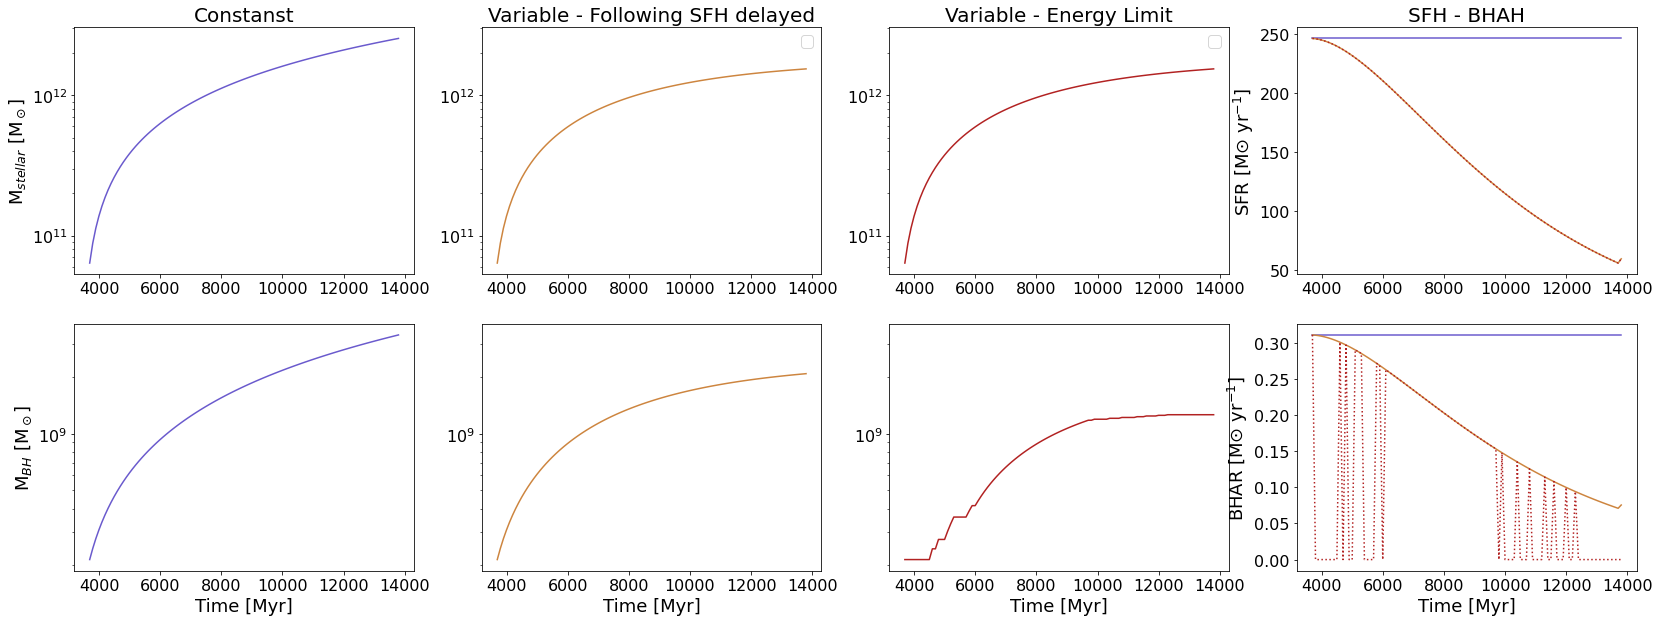

In [17]:
#fig, axs = plt.subplots(ncols=4, nrows=2, sharey=True, sharex='col', figsize=(28, 10))
#fig.suptitle('test title', fontsize=22)

fig = plt.figure(figsize=(28, 10))
ax1 = fig.add_subplot(2, 4, 1)
ax2 = fig.add_subplot(2, 4, 2, sharey = ax1)
ax3 = fig.add_subplot(2, 4, 3, sharey = ax1)
ax4 = fig.add_subplot(2, 4, 4)
ax5 = fig.add_subplot(2, 4, 5)
ax6 = fig.add_subplot(2, 4, 6, sharey = ax5)
ax7 = fig.add_subplot(2, 4, 7, sharey = ax5)
ax8 = fig.add_subplot(2, 4, 8)
############################
mode=1
time, mst_t, mbh_t, SFH1, BHH1=mass_to_z0(cosmo,Z[i],MBH[i],BHAR[i],MST[i],SFR[i],MGS[i],mode,Tm[i],Tb[i],Ab[i],F_burst[i])

#ax = axs[0,0]
ax = ax1
ax.set_title(r'Constanst',size=20)
ax.plot(time, mst_t.value, color='slateblue')
ax.set_yscale('log')
ax.set_ylabel(r'M$_{stellar}$ [M$_\odot$]',size=18)

ax = ax5
#ax = axs[1,0]
ax.plot(time, mbh_t.value, color='slateblue')
ax.set_yscale('log')
ax.set_ylabel(r'M$_{BH}$ [M$_\odot$]',size=18)
ax.set_xlabel(r'Time [Myr]',size=18)

#ax.annotate('z='+str(Z.round(3)), xy=(0.65, 0.05), xycoords='axes fraction', fontsize=18)
#############################
#############################
mode=2
time, mst_t, mbh_t, SFH2, BHH2=mass_to_z0(cosmo,Z[i],MBH[i],BHAR[i],MST[i],SFR[i],MGS[i],mode,Tm[i],Tb[i],Ab[i],F_burst[i])

#ax = axs[0,1]
ax = ax2
ax.set_title(r'Variable - Following SFH delayed',size=20)

ax.plot(time, mst_t.value, color='peru')
ax.set_yscale('log')
ax.legend()

ax = ax6
#ax = axs[1,1]
ax.plot(time, mbh_t.value, color='peru')
ax.set_yscale('log')
ax.set_xlabel(r'Time [Myr]',size=18)

#############################
#############################
mode=3
time, mst_t, mbh_t, SFH3, BHH3=mass_to_z0(cosmo,Z[i],MBH[i],BHAR[i],MST[i],SFR[i],MGS[i],mode,Tm[i],Tb[i],Ab[i],F_burst[i])

#ax = axs[0,2]
ax = ax3
ax.set_title(r'Variable - Energy Limit',size=20)

ax.plot(time, mst_t.value, color='firebrick')
ax.set_yscale('log')
ax.legend()

ax = ax7
#ax = axs[1,2]
ax.plot(time, mbh_t.value, color='firebrick')
ax.set_yscale('log')
ax.set_xlabel(r'Time [Myr]',size=18)
#############################
#############################
ax = ax4
#ax = axs[0,3]
#ax = plt.axes([0.85, 0.1, 0.075, 0.8])
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

ax.set_title(r'SFH - BHAH',size=20)
ax.set_ylabel(r'SFR [M$\odot$ yr$^{-1}$]',size=18)
ax.plot(time, SFH1.value, color='slateblue')
ax.plot(time, SFH2.value, color='peru')
ax.plot(time, SFH3.value, color='firebrick', linestyle='dotted')
#ax.set_yscale('log')

ax = ax8
#ax = axs[1,3]
ax.set_ylabel(r'BHAR [M$\odot$ yr$^{-1}$]',size=18)
ax.plot(time, BHH1.value, color='slateblue')
ax.plot(time, BHH2.value, color='peru')
ax.plot(time, BHH3.value, color='firebrick', linestyle='dotted')
ax.set_xlabel(r'Time [Myr]',size=18)

#ax.set_yscale('log')
#############################
plt.savefig(path_fig+'Going_Restframe.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()

In [18]:
def toZ0_plotis(ids,cosmo,red,massbh,massbh_dot,massst,massst_dot,massgas,tm,tb,ab,fb):
    #fig, axs = plt.subplots(ncols=4, nrows=2, sharey=True, sharex='col', figsize=(28, 10))

    fig = plt.figure(figsize=(28, 10))
    fig.suptitle(ids+' |  z='+str(red.round(2)), fontsize=22)
    ax1 = fig.add_subplot(2, 4, 1)
    ax2 = fig.add_subplot(2, 4, 2, sharey = ax1)
    ax3 = fig.add_subplot(2, 4, 3, sharey = ax1)
    ax4 = fig.add_subplot(2, 4, 4)
    ax5 = fig.add_subplot(2, 4, 5)
    ax6 = fig.add_subplot(2, 4, 6, sharey = ax5)
    ax7 = fig.add_subplot(2, 4, 7, sharey = ax5)
    ax8 = fig.add_subplot(2, 4, 8)
    ############################
    mode=1
    time, mst_t, mbh_t, SFH1, BHH1=mass_to_z0(cosmo,red,massbh,massbh_dot,massst,massst_dot,massgas,mode,tm,tb,ab,fb)

    #ax = axs[0,0]
    ax = ax1
    ax.set_title(r'Constanst',size=20)
    ax.plot(time, mst_t.value, color='slateblue')
    ax.set_yscale('log')
    ax.set_ylabel(r'M$_{stellar}$ [M$_\odot$]',size=18)

    ax = ax5
    #ax = axs[1,0]
    ax.plot(time, mbh_t.value, color='slateblue')
    ax.set_yscale('log')
    ax.set_ylabel(r'M$_{BH}$ [M$_\odot$]',size=18)
    ax.set_xlabel(r'Time [Myr]',size=18)

    #ax.annotate('z='+str(Z.round(3)), xy=(0.65, 0.05), xycoords='axes fraction', fontsize=18)
    #############################
    #############################
    mode=2
    time, mst_t, mbh_t, SFH2, BHH2=mass_to_z0(cosmo,red,massbh,massbh_dot,massst,massst_dot,massgas,mode,tm,tb,ab,fb)

    #ax = axs[0,1]
    ax = ax2
    ax.set_title(r'Variable - Following SFH delayed',size=20)

    ax.plot(time, mst_t.value, color='peru')
    ax.set_yscale('log')

    ax = ax6
    #ax = axs[1,1]
    ax.plot(time, mbh_t.value, color='peru')
    ax.set_yscale('log')
    ax.set_xlabel(r'Time [Myr]',size=18)

    #############################
    #############################
    mode=3
    time, mst_t, mbh_t, SFH3, BHH3=mass_to_z0(cosmo,red,massbh,massbh_dot,massst,massst_dot,massgas,mode,tm,tb,ab,fb)

    #ax = axs[0,2]
    ax = ax3
    ax.set_title(r'Variable - Energy Limit',size=20)

    ax.plot(time, mst_t.value, color='firebrick')
    ax.set_yscale('log')

    ax = ax7
    #ax = axs[1,2]
    ax.plot(time, mbh_t.value, color='firebrick')
    ax.set_yscale('log')
    ax.set_xlabel(r'Time [Myr]',size=18)
    #############################
    #############################
    ax = ax4
    #ax = axs[0,3]
    #ax = plt.axes([0.85, 0.1, 0.075, 0.8])
    #plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

    ax.set_title(r'SFH - BHAH',size=20)
    ax.set_ylabel(r'SFR [M$\odot$ yr$^{-1}$]',size=18)
    ax.plot(time, SFH1.value, color='slateblue')
    ax.plot(time, SFH2.value, color='peru')
    ax.plot(time, SFH3.value, color='firebrick', linestyle='dotted')
    #ax.set_yscale('log')

    ax = ax8
    #ax = axs[1,3]
    ax.set_ylabel(r'BHAR [M$\odot$ yr$^{-1}$]',size=18)
    ax.plot(time, BHH1.value, color='slateblue')
    ax.plot(time, BHH2.value, color='peru')
    ax.plot(time, BHH3.value, color='firebrick', linestyle='dotted')
    ax.set_xlabel(r'Time [Myr]',size=18)

    #ax.set_yscale('log')
    #############################
    plt.savefig(path_fig+'toZ0/'+ids+'.png', dpi=300, transparent=False, bbox_inches='tight')
    plt.close()
    del fig
    return 

In [19]:
for i in range(len(ID)):
    print('working in '+ID[i]+' ...')
    toZ0_plotis(ID[i],cosmo,Z[i],MBH[i],BHAR[i],MST[i],SFR[i],MGS[i],Tm[i],Tb[i],Ab[i],F_burst[i])
print('finished')

working in aegis_026 ...
working in aegis_029 ...
working in aegis_035 ...
working in aegis_036 ...
working in aegis_037 ...
working in aegis_040 ...
working in aegis_044 ...
working in aegis_058 ...
working in aegis_062 ...
working in aegis_120 ...
working in aegis_165 ...
working in aegis_192 ...
working in aegis_202 ...
working in aegis_217 ...
working in aegis_254 ...
working in aegis_278 ...
working in aegis_287 ...
working in aegis_298 ...
working in aegis_321 ...
working in aegis_342 ...
working in aegis_399 ...
working in aegis_407 ...
working in aegis_492 ...
working in aegis_505 ...
working in aegis_543 ...
working in aegis_594 ...
working in aegis_622 ...
working in aegis_658 ...
working in aegis_722 ...
working in aegis_736 ...
working in aegis_742 ...
working in aegis_760 ...
working in aegis_782 ...
working in aegis_806 ...
working in aegis_844 ...
working in aegis_861 ...
working in aegis_863 ...
working in aegis_888 ...
working in aegis_909 ...
working in aegis_914 ...


In [20]:
MST_md1=MST.copy()
MBH_md1=MBH.copy()
MST_md2=MST.copy()
MBH_md2=MBH.copy()
MST_md3=MST.copy()
MBH_md3=MBH.copy()

for i in range(len(ID)):
    mode=1
    time, mst_t, mbh_t, SFH, BHH=mass_to_z0(cosmo,Z[i],MBH[i],BHAR[i],MST[i],SFR[i],MGS[i],mode,Tm[i],Tb[i],Ab[i],F_burst[i])
    MST_md1[i],MBH_md1[i]=mst_t[-1],mbh_t[-1]
    mode=2
    time, mst_t, mbh_t, SFH, BHH=mass_to_z0(cosmo,Z[i],MBH[i],BHAR[i],MST[i],SFR[i],MGS[i],mode,Tm[i],Tb[i],Ab[i],F_burst[i])
    MST_md2[i],MBH_md2[i]=mst_t[-1],mbh_t[-1]
    mode=3
    time, mst_t, mbh_t, SFH, BHH=mass_to_z0(cosmo,Z[i],MBH[i],BHAR[i],MST[i],SFR[i],MGS[i],mode,Tm[i],Tb[i],Ab[i],F_burst[i])
    MST_md3[i],MBH_md3[i]=mst_t[-1],mbh_t[-1]

MST_md1=MST_md1
MBH_md1=MBH_md1
MST_md2=MST_md2
MBH_md2=MBH_md2
MST_md3=MST_md3
MBH_md3=MBH_md3

In [21]:
with_mbh=~np.isnan(MBH.value)

saving=np.array([MST.value,MST_md1.value,MST_md2.value,MST_md3.value])
np.savetxt(deli+'MST.dat',saving,header='Stellar Mass in Msun - Measured - Cte mode - Following SFH - Following SFH and energy limit')

saving=np.array([MBH.value,MBH_md1.value,MBH_md2.value,MBH_md3.value])
np.savetxt(deli+'MBH.dat',saving,header='BH Mass in Msun - Measured - Cte mode - Following SFH - Following SFH and energy limit')

saving=np.array([xsaf['bayes.stellar.m_star_err'][with_mbh]/MST[with_mbh].value])
np.savetxt(deli+'MST_err.dat',saving,header='Stellar Mass errors relatives - Measured')

saving=np.array([xsaf['logMbh_err'][with_mbh]])
np.savetxt(deli+'MBH_err.dat',saving,header='BH Mass errors relatives - Measured')

In [22]:
ID[np.logical_and(MBH_md3.value>1e09,MST_md3.value<1e11)]

aegis_040
aegis_165


/home/ivan/Softwares/miniconda3/envs/astroutils/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


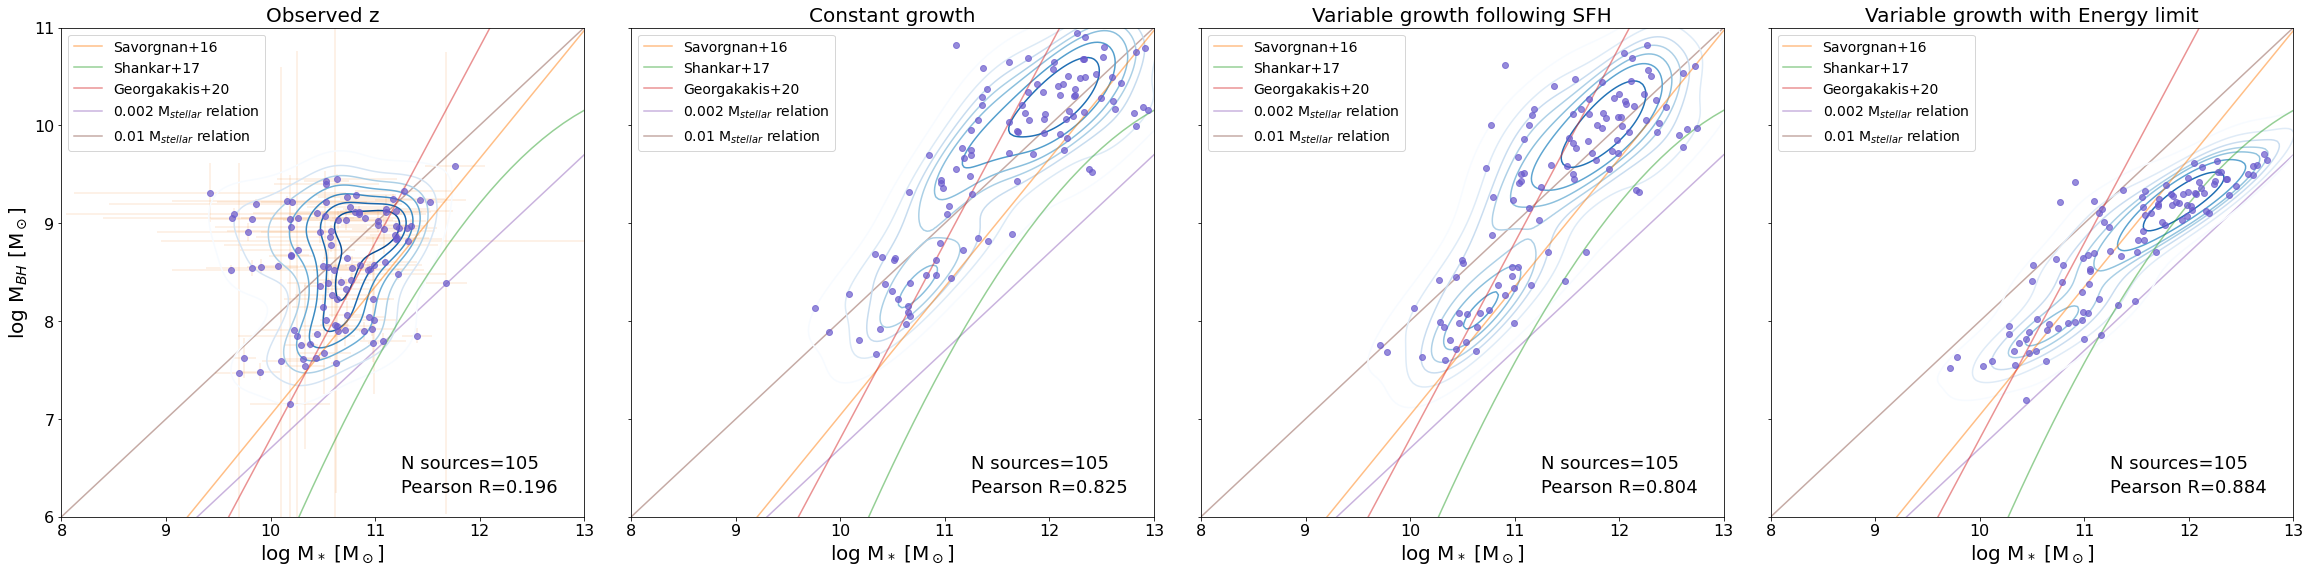

In [23]:
def bh_savorgnan(ste_mass):
    logbh = 8.35+1.31*(ste_mass-11)
    return logbh

def bh_unbias_shankar(ste_mass):
    logbh = 7.574+1.946*(ste_mass-11)-0.306*(ste_mass-11)**2-0.011*(ste_mass-11)**3
    return logbh

def bh_georgakakis(ste_mass):
    logbh = 6.8+2*(ste_mass-10)
    return logbh

xmin,xmax,ymin,ymax=8,13,6,11
fig, axs = plt.subplots(ncols=4,sharey=True, figsize=(40, 9))
fig.subplots_adjust(wspace=0.09)

with_mbh=~np.isnan(MBH.value)

ax = axs[0]
ax.set_title('Observed z',size=20)

toplot_x, toplot_y=np.log10(MST[with_mbh].value), np.log10(MBH[with_mbh].value)
x_err=xsaf['bayes.stellar.m_star_err'][with_mbh]/MST[with_mbh].value
y_err =xsaf['logMbh_err'][with_mbh]

ax.scatter(toplot_x, toplot_y, c='slateblue', alpha=0.7, zorder=3)
sns.kdeplot(toplot_x+1-1, toplot_y+1-1, ax=ax, cmap="Blues", alpha=1, levels=8, thresh=.1)#,cbar=True)
ax.errorbar(toplot_x, toplot_y, xerr=x_err, yerr=y_err, fmt='.', barsabove=True, color='white', ecolor='sandybrown',alpha=0.2, zorder=1)

ax.plot(np.arange(xmin,xmax+1),bh_savorgnan(np.arange(xmin,xmax+1)), alpha=0.5,label='Savorgnan+16')
ax.plot(np.arange(xmin,xmax+1,0.1),bh_unbias_shankar(np.arange(xmin,xmax+1,0.1)), alpha=0.5,label='Shankar+17')
ax.plot(np.arange(xmin,xmax+1),bh_georgakakis(np.arange(xmin,xmax+1)), alpha=0.5,label='Georgakakis+20')
ax.plot(np.arange(xmin,xmax+1),np.arange(xmin,xmax+1)-3.3, alpha=0.5, label=r'0.002 M$_{stellar}$ relation',zorder=1)
ax.plot(np.arange(xmin,xmax+1),np.arange(xmin,xmax+1)-2, alpha=0.5, label=r'0.01 M$_{stellar}$ relation',zorder=1)
ax.legend(loc='upper left',fontsize=14)

result = scipy.stats.linregress(toplot_x,toplot_y)
ax.annotate('N sources='+str(len(toplot_x)), xy=(0.65, 0.10), xycoords='axes fraction', fontsize=18)
ax.annotate('Pearson R='+str(result.rvalue.round(3)), xy=(0.65, 0.05), xycoords='axes fraction', fontsize=18)

ax.set_xlabel(r'log M$_*$ [M$_\odot$]',size=20)
ax.set_ylabel(r'log M$_{BH}$ [M$_\odot$]',size=20)
ax.axis([xmin, xmax, ymin, ymax])

#############################
ax = axs[1]
ax.set_title('Constant growth',size=20)

toplot_x, toplot_y=np.log10(MST_md1[with_mbh].value), np.log10(MBH_md1[with_mbh].value)

ax.scatter(toplot_x, toplot_y, c='slateblue', alpha=0.7, zorder=3)
sns.kdeplot(x=toplot_x, y=toplot_y, ax=ax, cmap="Blues", alpha=1, levels=8, thresh=.1)#,cbar=True)
ax.plot(np.arange(xmin,xmax+1),bh_savorgnan(np.arange(xmin,xmax+1)), alpha=0.5,label='Savorgnan+16')
ax.plot(np.arange(xmin,xmax+1,0.1),bh_unbias_shankar(np.arange(xmin,xmax+1,0.1)), alpha=0.5,label='Shankar+17')
ax.plot(np.arange(xmin,xmax+1),bh_georgakakis(np.arange(xmin,xmax+1)), alpha=0.5,label='Georgakakis+20')
ax.plot(np.arange(xmin,xmax+1),np.arange(xmin,xmax+1)-3.3, alpha=0.5, label=r'0.002 M$_{stellar}$ relation',zorder=1)
ax.plot(np.arange(xmin,xmax+1),np.arange(xmin,xmax+1)-2, alpha=0.5, label=r'0.01 M$_{stellar}$ relation',zorder=1)
ax.legend(loc='upper left',fontsize=14)

result = scipy.stats.linregress(toplot_x,toplot_y)
ax.annotate('N sources='+str(len(toplot_x)), xy=(0.65, 0.10), xycoords='axes fraction', fontsize=18)
ax.annotate('Pearson R='+str(result.rvalue.round(3)), xy=(0.65, 0.05), xycoords='axes fraction', fontsize=18)

ax.set_xlabel(r'log M$_*$ [M$_\odot$]',size=20)
ax.set_ylabel(r'log M$_{BH}$ [M$_\odot$]',size=20)
ax.axis([xmin, xmax, ymin, ymax])

###########################
ax = axs[2]
ax.set_title(r'Variable growth following SFH',size=20)

toplot_x, toplot_y=np.log10(MST_md2[with_mbh].value), np.log10(MBH_md2[with_mbh].value)

ax.scatter(toplot_x, toplot_y, c='slateblue', alpha=0.7, zorder=3)
sns.kdeplot(x=toplot_x, y=toplot_y, ax=ax, cmap="Blues", alpha=1, levels=8, thresh=.1)#,cbar=True)
ax.plot(np.arange(xmin,xmax+1),bh_savorgnan(np.arange(xmin,xmax+1)), alpha=0.5,label='Savorgnan+16')
ax.plot(np.arange(xmin,xmax+1,0.1),bh_unbias_shankar(np.arange(xmin,xmax+1,0.1)), alpha=0.5,label='Shankar+17')
ax.plot(np.arange(xmin,xmax+1),bh_georgakakis(np.arange(xmin,xmax+1)), alpha=0.5,label='Georgakakis+20')
ax.plot(np.arange(xmin,xmax+1),np.arange(xmin,xmax+1)-3.3, alpha=0.5, label=r'0.002 M$_{stellar}$ relation',zorder=1)
ax.plot(np.arange(xmin,xmax+1),np.arange(xmin,xmax+1)-2, alpha=0.5, label=r'0.01 M$_{stellar}$ relation',zorder=1)
ax.legend(loc='upper left',fontsize=14)

result = scipy.stats.linregress(toplot_x,toplot_y)
ax.annotate('N sources='+str(len(toplot_x)), xy=(0.65, 0.10), xycoords='axes fraction', fontsize=18)
ax.annotate('Pearson R='+str(result.rvalue.round(3)), xy=(0.65, 0.05), xycoords='axes fraction', fontsize=18)

ax.set_xlabel(r'log M$_*$ [M$_\odot$]',size=20)
ax.set_ylabel(r'log M$_{BH}$ [M$_\odot$]',size=20)
ax.axis([xmin, xmax, ymin, ymax])

############################
ax = axs[3]
ax.set_title(r'Variable growth with Energy limit',size=20)

toplot_x, toplot_y=np.log10(MST_md3[with_mbh].value), np.log10(MBH_md3[with_mbh].value)

ax.scatter(toplot_x, toplot_y, c='slateblue', alpha=0.7, zorder=3)
sns.kdeplot(x=toplot_x, y=toplot_y, ax=ax, cmap="Blues", alpha=1, levels=8, thresh=.1)#,cbar=True)

ax.plot(np.arange(xmin,xmax+1),bh_savorgnan(np.arange(xmin,xmax+1)), alpha=0.5,label='Savorgnan+16')
ax.plot(np.arange(xmin,xmax+1,0.1),bh_unbias_shankar(np.arange(xmin,xmax+1,0.1)), alpha=0.5,label='Shankar+17')
ax.plot(np.arange(xmin,xmax+1),bh_georgakakis(np.arange(xmin,xmax+1)), alpha=0.5,label='Georgakakis+20')
ax.plot(np.arange(xmin,xmax+1),np.arange(xmin,xmax+1)-3.3, alpha=0.5, label=r'0.002 M$_{stellar}$ relation',zorder=1)
ax.plot(np.arange(xmin,xmax+1),np.arange(xmin,xmax+1)-2, alpha=0.5, label=r'0.01 M$_{stellar}$ relation',zorder=1)
ax.legend(loc='upper left',fontsize=14)

ax.set_xlabel(r'log M$_*$ [M$_\odot$]',size=20)
ax.set_ylabel(r'log M$_{BH}$ [M$_\odot$]',size=20)
ax.axis([xmin, xmax, ymin, ymax])

result = scipy.stats.linregress(toplot_x,toplot_y)
ax.annotate('N sources='+str(len(toplot_x)), xy=(0.65, 0.10), xycoords='axes fraction', fontsize=18)
ax.annotate('Pearson R='+str(result.rvalue.round(3)), xy=(0.65, 0.05), xycoords='axes fraction', fontsize=18)

plt.savefig(path_fig+'M-M_Z0.png', dpi=500, transparent=False, bbox_inches='tight')
plt.show()

In [49]:
#RANDOM EVOLUTION
from random import seed
#ORIGINAL VALUES
#AGN
MBH=        10**xsaf['logMbh_best']*u.Msun
LAGN=       (xsaf['bayes.agn.accretion_power']*u.W).to(u.erg/u.s)

#Host
MST =       xsaf['bayes.stellar.m_star'] *u.Msun
MGS =       xsaf['bayes.stellar.m_gas'] *u.Msun
Z=          xsaf['Z_Spec']
SFR=        xsaf['bayes.sfh.sfr']        *u.Msun/u.yr
Tm=         xsaf['bayes.sfh.tau_main']    #*u.Myr
Tb=         xsaf['bayes.sfh.tau_burst']
Ab=         xsaf['bayes.sfh.age_burst']
F_burst=    xsaf['bayes.sfh.f_burst']
ID=xsaf['id']

# #MODIFYING THE SAMPLE
# n=len(Z)

# #AGN
# #LAGN
# random_mean=np.log10(LAGN.value).mean()
# random_scatter=np.log10(LAGN.value).std()
# LAGN=np.random.normal(loc=random_mean,scale=random_scatter,size=n)
# LAGN= 10**LAGN * u.erg/u.s

# EDD=         LAGN.value/(1.3E38*MBH.value)
# BHAR=np.array([])
# for i in range(len(MBH.value)):
#     BHAR=np.append(BHAR,Mdot(LAGN[i],MBH[i]).value)
# BHAR=       BHAR                         *u.Msun/u.yr

# #Host
# #SFR
# random_mean=np.log10(SFR.value).mean()
# random_scatter=np.log10(SFR.value).std()
# SFR=np.random.normal(loc=random_mean,scale=random_scatter,size=n)
# SFR= 10**SFR *u.Msun/u.yr

# #SFH
# random_mean=Tm.mean()
# random_scatter=Tm.std()
# Tm=np.random.normal(loc=random_mean,scale=random_scatter,size=n)

# random_mean=Ab.mean()
# random_scatter=Ab.std()
# Ab=np.random.normal(loc=random_mean,scale=random_scatter,size=n)

# random_mean=F_burst.mean()
# random_scatter=F_burst.std()
# F_burst=np.random.normal(loc=random_mean,scale=random_scatter,size=n)

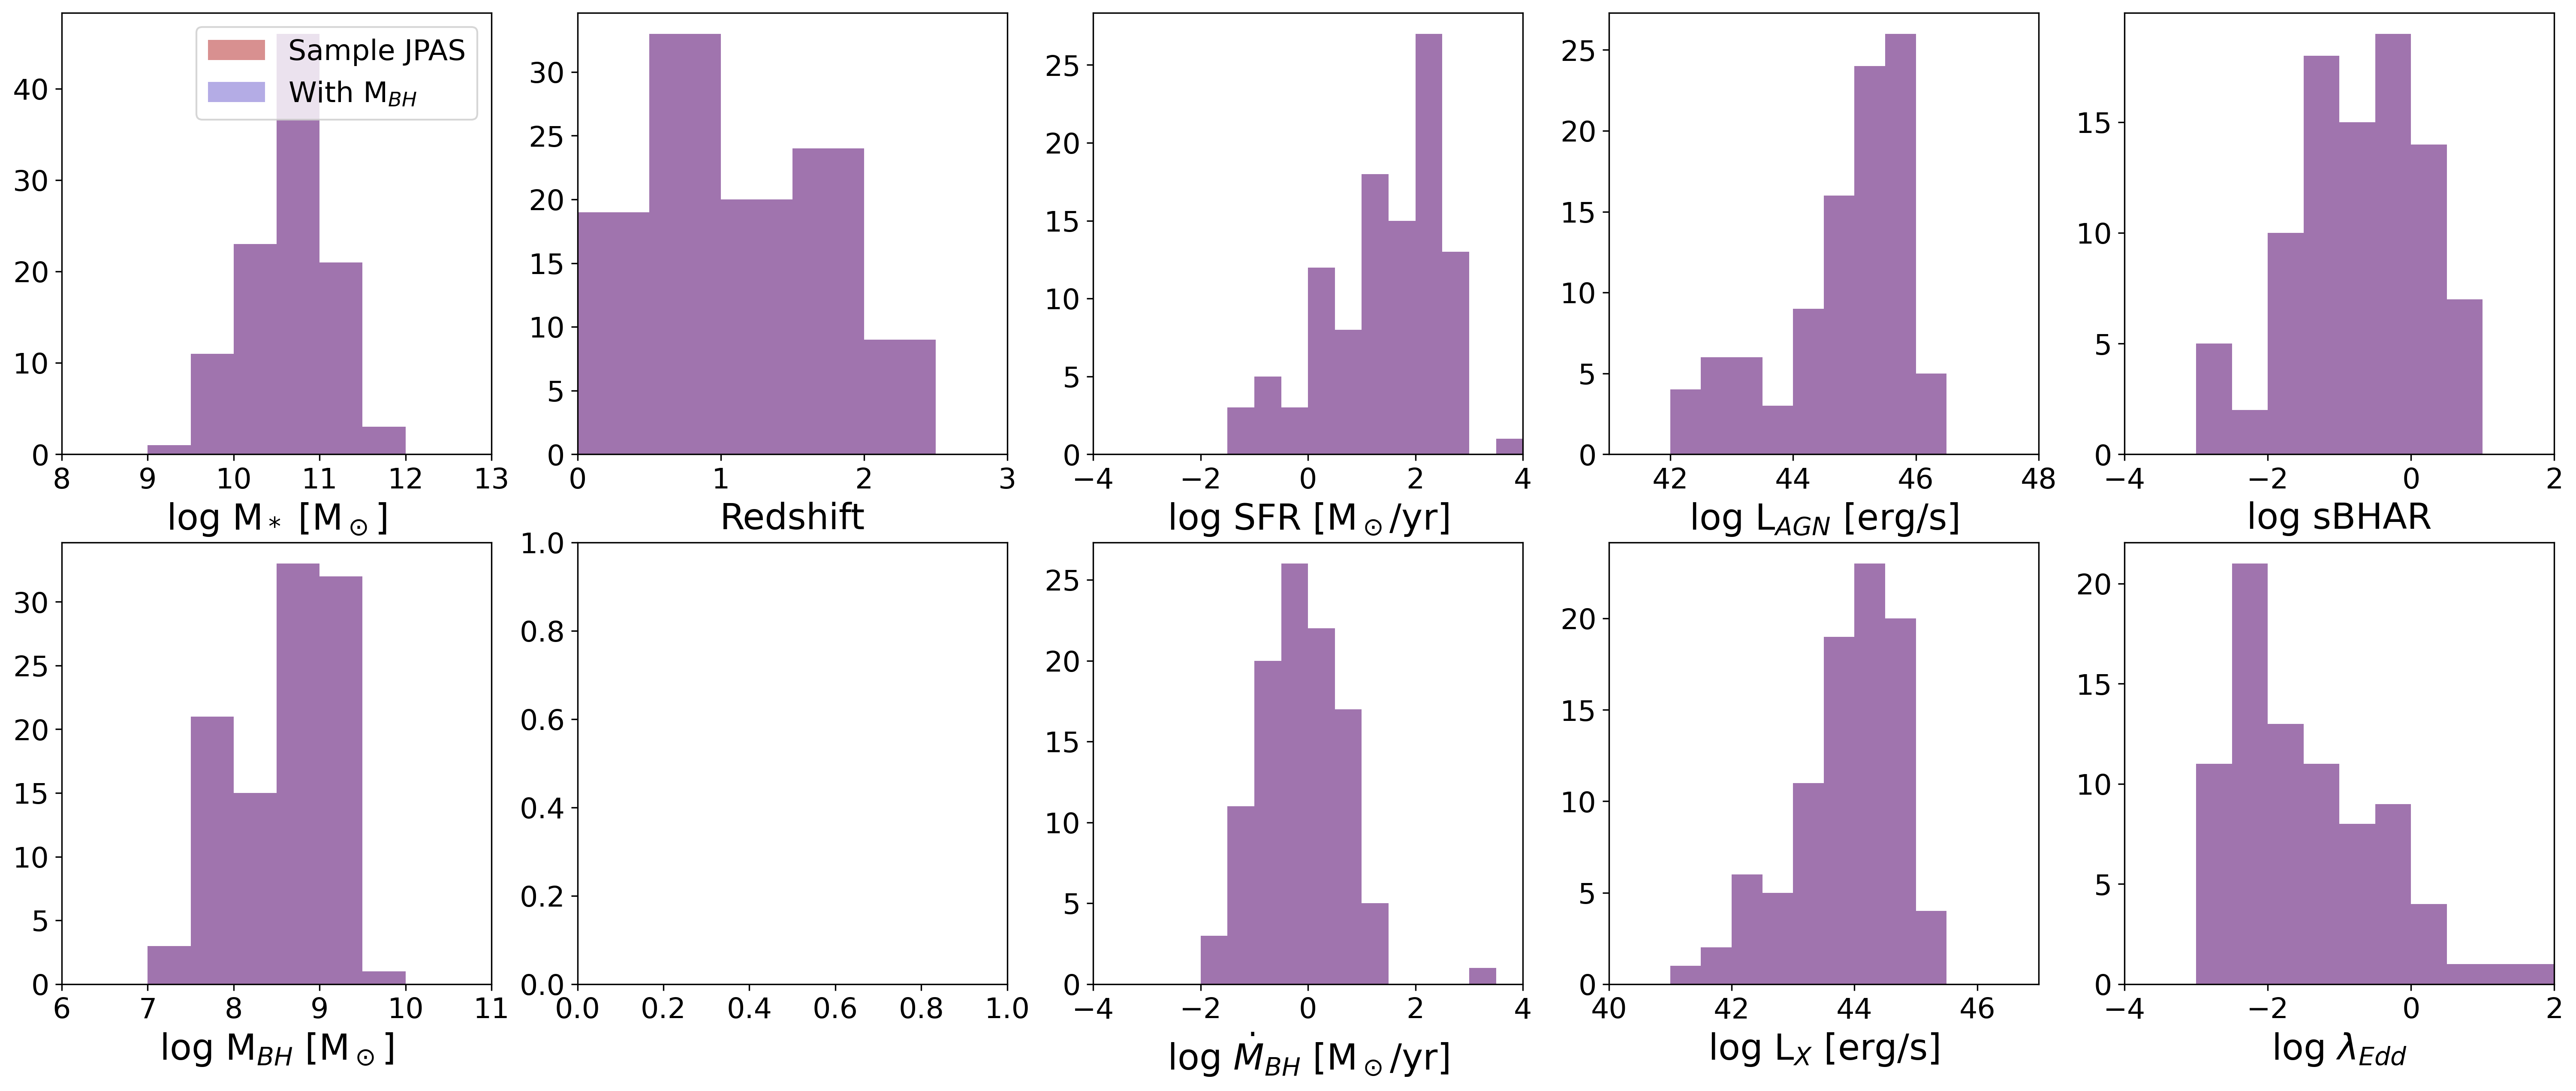

In [50]:
#sns.set_style("white")
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(25, 10), dpi=300)

#M*
ax = axs[0,0]
xmin,xmax=8,13
plot_x=np.log10(MST.value)
with_mbh=~np.isnan(MBH.value)
ax.hist(plot_x,bins=np.arange(xmin+1,xmax+1,0.5), color='firebrick', alpha=0.5, zorder=1, label='Sample JPAS')
ax.hist(plot_x[with_mbh],bins=np.arange(xmin+1,xmax+1,0.5), color='slateblue', alpha=0.5, zorder=1, label=r'With M$_{BH}$')
ax.legend()
ax.axis(xmin=xmin, xmax=xmax)
ax.set_xlabel(r'log M$_*$ [M$_\odot$]',size=20)
#######

#MBH
ax = axs[1,0]
plot_x=np.log10(MBH.value)
xmin,xmax=6,11
ax.hist(plot_x,bins=np.arange(xmin+1,xmax+1,0.5), color='firebrick', alpha=0.5, zorder=1, label=r'With M$_{BH}$')
ax.hist(plot_x[with_mbh],bins=np.arange(xmin+1,xmax+1,0.5), color='slateblue', alpha=0.5, zorder=1, label=r'With M$_{BH}$')
ax.axis(xmin=xmin, xmax=xmax)
ax.set_xlabel(r'log M$_{BH}$ [M$_\odot$]',size=20)
#######

#Z
ax = axs[0,1]
plot_x=Z
xmin,xmax=-1,3
ax.hist(plot_x,bins=np.arange(xmin+1,xmax+1,0.5), color='firebrick', alpha=0.5, zorder=1, label='JPAS-Sample')
ax.hist(plot_x[with_mbh],bins=np.arange(xmin+1,xmax+1,0.5), color='slateblue', alpha=0.5, zorder=1, label=r'With M$_{BH}$')
ax.axis(xmin=xmin+1, xmax=xmax)
ax.set_xlabel(r'Redshift',size=20)
#######

#ENsSFR
# ax = axs[1,1]
# plot_x=ENSSFR
# xmin,xmax=-6,3
# ax.hist(plot_x,bins=np.arange(xmin+1,xmax+1,0.5), color='firebrick', alpha=0.5, zorder=1, label='JPAS-Sample')
# ax.hist(plot_x[with_mbh],bins=np.arange(xmin+1,xmax+1,0.5), color='slateblue', alpha=0.5, zorder=1, label=r'With M$_{BH}$')
# ax.vlines(-1.2,0,55,colors='grey',linestyles='dotted')
# ax.annotate('Quiescent', xy=(-3.8, 50), fontsize=14)
# ax.annotate('Star-forming', xy=(-1, 50), fontsize=14)
# ax.axis(xmin=xmin, xmax=xmax)
# ax.set_xlabel(r'log ENsSFR [1/yr]',size=20)
#######

#SFR
ax = axs[0,2]
plot_x=np.log10(SFR.value)
xmin,xmax=-4,4
ax.hist(plot_x,bins=np.arange(xmin+1,xmax+1,0.5), color='firebrick', alpha=0.5, zorder=1, label='JPAS-Sample')
ax.hist(plot_x[with_mbh],bins=np.arange(xmin+1,xmax+1,0.5), color='slateblue', alpha=0.5, zorder=1, label=r'With M$_{BH}$')
ax.axis(xmin=xmin, xmax=xmax)
ax.set_xlabel(r'log SFR [M$_\odot$/yr]',size=20)
#######

#MBHdot
ax = axs[1,2]
plot_x=np.log10(BHAR.value)
xmin,xmax=-4,4
ax.hist(plot_x,bins=np.arange(xmin+1,xmax+1,0.5), color='firebrick', alpha=0.5, zorder=1, label='JPAS-Sample')
ax.hist(plot_x[with_mbh],bins=np.arange(xmin+1,xmax+1,0.5), color='slateblue', alpha=0.5, zorder=1, label=r'With M$_{BH}$')
ax.axis(xmin=xmin, xmax=xmax)
ax.set_xlabel(r'log $\dot{M}_{BH}$ [M$_\odot$/yr]',size=20)
#######

#LAGN
ax = axs[0,3]
plot_x=np.log10(LAGN.to(u.erg/u.s).value)
xmin,xmax=41,48
ax.hist(plot_x,bins=np.arange(xmin+1,xmax+1,0.5), color='firebrick', alpha=0.5, zorder=1, label='JPAS-Sample')
ax.hist(plot_x[with_mbh],bins=np.arange(xmin+1,xmax+1,0.5), color='slateblue', alpha=0.5, zorder=1, label=r'With M$_{BH}$')
ax.axis(xmin=xmin, xmax=xmax)
ax.set_xlabel(r'log L$_{AGN}$ [erg/s]',size=20)
#######

#LX
ax = axs[1,3]
plot_x=np.log10(LX.to(u.erg/u.s).value)
xmin,xmax=40,47
ax.hist(plot_x,bins=np.arange(xmin+1,xmax+1,0.5), color='firebrick', alpha=0.5, zorder=1, label='JPAS-Sample')
ax.hist(plot_x[with_mbh],bins=np.arange(xmin+1,xmax+1,0.5), color='slateblue', alpha=0.5, zorder=1, label=r'With M$_{BH}$')
ax.axis(xmin=xmin, xmax=xmax)
ax.set_xlabel(r'log L$_{X}$ [erg/s]',size=20)
#######

#sBHAR
ax = axs[0,4]
plot_x=np.log10((25*LX.value)/(1.3E38*0.002*MST.value))
xmin,xmax=-4,2
ax.hist(plot_x,bins=np.arange(xmin+1,xmax+1,0.5), color='firebrick', alpha=0.5, zorder=1, label='JPAS-Sample')
ax.hist(plot_x[with_mbh],bins=np.arange(xmin+1,xmax+1,0.5), color='slateblue', alpha=0.5, zorder=1, label=r'With M$_{BH}$')
ax.axis(xmin=xmin, xmax=xmax)
ax.set_xlabel(r'log sBHAR',size=20)
#######

#Edd
ax = axs[1,4]
plot_x=np.log10(EDD)
xmin,xmax=-4,2
ax.hist(plot_x,bins=np.arange(xmin+1,xmax+1,0.5), color='firebrick', alpha=0.5, zorder=1, label='JPAS-Sample')
ax.hist(plot_x[with_mbh],bins=np.arange(xmin+1,xmax+1,0.5), color='slateblue', alpha=0.5, zorder=1, label='JPAS-Sample')
ax.axis(xmin=xmin, xmax=xmax)
ax.set_xlabel(r'log $\lambda_{Edd}$',size=20)
#######

plt.savefig(path_fig+'Hist_1_random.png', dpi=300, transparent=False, bbox_inches='tight')

In [53]:
MST_md1=MST.copy()
MBH_md1=MBH.copy()
MST_md2=MST.copy()
MBH_md2=MBH.copy()
MST_md3=MST.copy()
MBH_md3=MBH.copy()

nro_random=100

for i in range(len(ID)):
    bh_mass1=0
    st_mass1=0
    bh_mass2=0
    st_mass2=0
    bh_mass3=0
    st_mass3=0
    for j in range(nro_random):
        #MODIFYING THE SAMPLE
        random_mean=np.log10(LAGN.value).mean()
        random_scatter=np.log10(LAGN.value).std()
        LAGN=np.random.normal(loc=random_mean,scale=random_scatter,size=1)[0]
        LAGN= 10**LAGN * u.erg/u.s
        BHAR=Mdot(LAGN,MBH[i]).value*u.Msun/u.yr

        #Host
        #SFR
        random_mean=np.log10(SFR.value).mean()
        random_scatter=np.log10(SFR.value).std()
        SFR=np.random.normal(loc=random_mean,scale=random_scatter,size=1)[0]
        SFR= 10**SFR *u.Msun/u.yr

        #SFH
        random_mean=Tm.mean()
        random_scatter=Tm.std()
        Tm=np.random.normal(loc=random_mean,scale=random_scatter,size=1)[0]

        random_mean=Ab.mean()
        random_scatter=Ab.std()
        Ab=np.random.normal(loc=random_mean,scale=random_scatter,size=1)[0]

        random_mean=F_burst.mean()
        random_scatter=F_burst.std()
        F_burst=np.random.normal(loc=random_mean,scale=random_scatter,size=1)[0]

        mode=1
        time, mst_t, mbh_t, SFH, BHH=mass_to_z0(cosmo,Z[i],MBH[i],BHAR,MST[i],SFR,MGS[i],mode,Tm,Tb[i],Ab,F_burst)
        bh_mass1+=mbh_t[-1]
        st_mass1+=mst_t[-1]
        mode=2
        time, mst_t, mbh_t, SFH, BHH=mass_to_z0(cosmo,Z[i],MBH[i],BHAR,MST[i],SFR,MGS[i],mode,Tm,Tb[i],Ab,F_burst)
        bh_mass2+=mbh_t[-1]
        st_mass2+=mst_t[-1]
        mode=3
        time, mst_t, mbh_t, SFH, BHH=mass_to_z0(cosmo,Z[i],MBH[i],BHAR,MST[i],SFR,MGS[i],mode,Tm,Tb[i],Ab,F_burst)
        bh_mass3+=mbh_t[-1]
        st_mass3+=mst_t[-1]
    MST_md1[i]=st_mass1/nro_random
    MBH_md1[i]=bh_mass1/nro_random
    MST_md2[i]=st_mass2/nro_random
    MBH_md2[i]=bh_mass2/nro_random
    MST_md3[i]=st_mass3/nro_random
    MBH_md3[i]=bh_mass3/nro_random

MST_md1=MST_md1
MBH_md1=MBH_md1
MST_md2=MST_md2
MBH_md2=MBH_md2
MST_md3=MST_md3
MBH_md3=MBH_md3

/home/ivan/Softwares/miniconda3/envs/astroutils/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


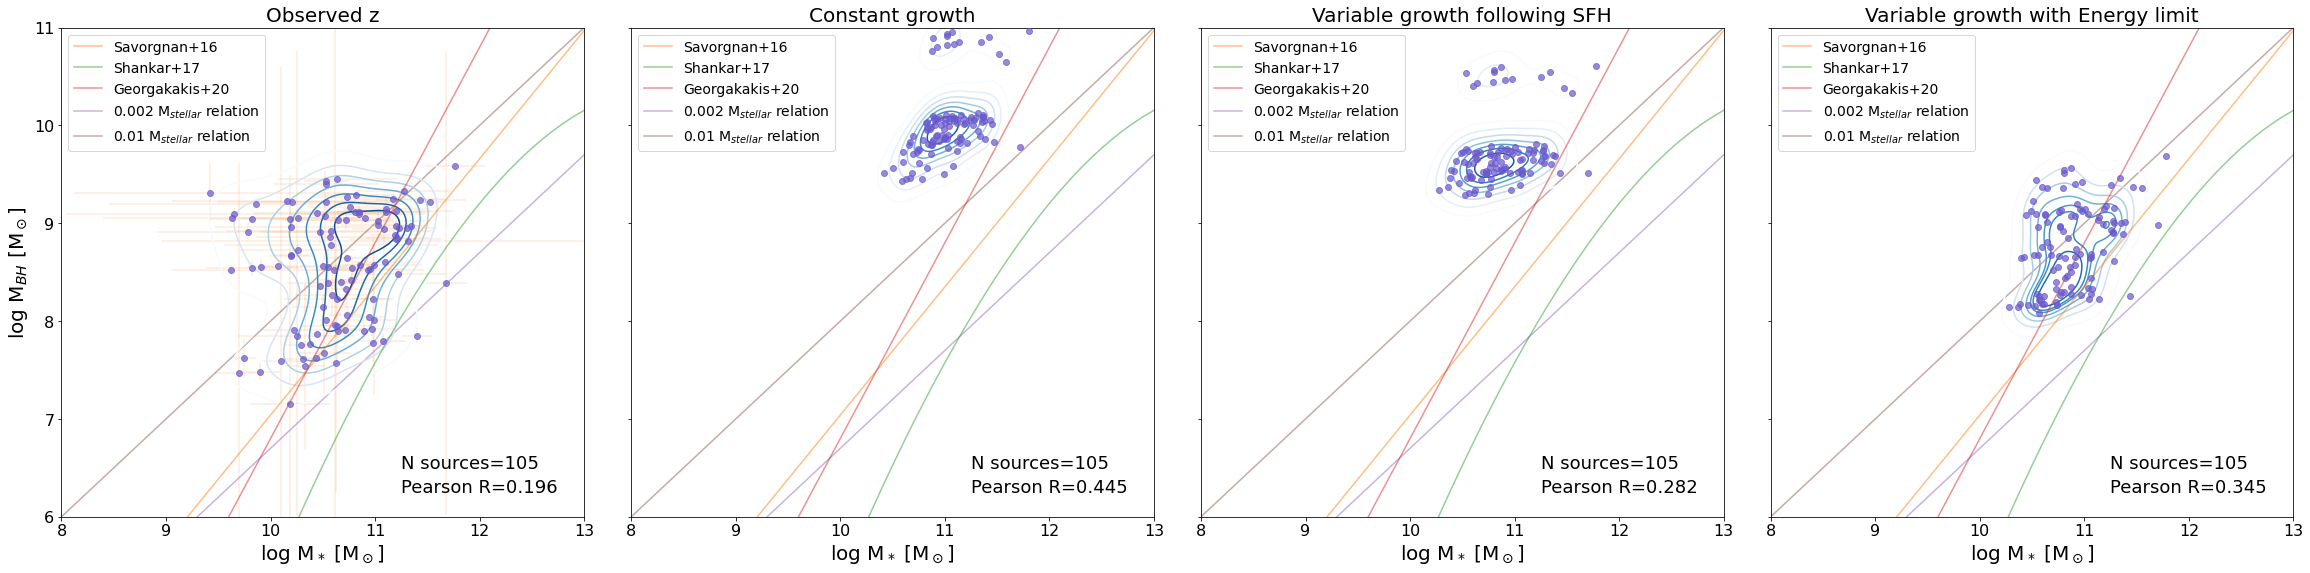

In [54]:
def bh_savorgnan(ste_mass):
    logbh = 8.35+1.31*(ste_mass-11)
    return logbh

def bh_unbias_shankar(ste_mass):
    logbh = 7.574+1.946*(ste_mass-11)-0.306*(ste_mass-11)**2-0.011*(ste_mass-11)**3
    return logbh

def bh_georgakakis(ste_mass):
    logbh = 6.8+2*(ste_mass-10)
    return logbh

xmin,xmax,ymin,ymax=8,13,6,11
fig, axs = plt.subplots(ncols=4,sharey=True, figsize=(40, 9))
fig.subplots_adjust(wspace=0.09)

with_mbh=~np.isnan(MBH.value)

ax = axs[0]
ax.set_title('Observed z',size=20)

toplot_x, toplot_y=np.log10(MST[with_mbh].value), np.log10(MBH[with_mbh].value)
x_err=xsaf['bayes.stellar.m_star_err'][with_mbh]/MST[with_mbh].value
y_err =xsaf['logMbh_err'][with_mbh]

ax.scatter(toplot_x, toplot_y, c='slateblue', alpha=0.7, zorder=3)
sns.kdeplot(toplot_x+1-1, toplot_y+1-1, ax=ax, cmap="Blues", alpha=1, levels=8, thresh=.1)#,cbar=True)
ax.errorbar(toplot_x, toplot_y, xerr=x_err, yerr=y_err, fmt='.', barsabove=True, color='white', ecolor='sandybrown',alpha=0.2, zorder=1)

ax.plot(np.arange(xmin,xmax+1),bh_savorgnan(np.arange(xmin,xmax+1)), alpha=0.5,label='Savorgnan+16')
ax.plot(np.arange(xmin,xmax+1,0.1),bh_unbias_shankar(np.arange(xmin,xmax+1,0.1)), alpha=0.5,label='Shankar+17')
ax.plot(np.arange(xmin,xmax+1),bh_georgakakis(np.arange(xmin,xmax+1)), alpha=0.5,label='Georgakakis+20')
ax.plot(np.arange(xmin,xmax+1),np.arange(xmin,xmax+1)-3.3, alpha=0.5, label=r'0.002 M$_{stellar}$ relation',zorder=1)
ax.plot(np.arange(xmin,xmax+1),np.arange(xmin,xmax+1)-2, alpha=0.5, label=r'0.01 M$_{stellar}$ relation',zorder=1)
ax.legend(loc='upper left',fontsize=14)

result = scipy.stats.linregress(toplot_x,toplot_y)
ax.annotate('N sources='+str(len(toplot_x)), xy=(0.65, 0.10), xycoords='axes fraction', fontsize=18)
ax.annotate('Pearson R='+str(result.rvalue.round(3)), xy=(0.65, 0.05), xycoords='axes fraction', fontsize=18)

ax.set_xlabel(r'log M$_*$ [M$_\odot$]',size=20)
ax.set_ylabel(r'log M$_{BH}$ [M$_\odot$]',size=20)
ax.axis([xmin, xmax, ymin, ymax])

#############################
ax = axs[1]
ax.set_title('Constant growth',size=20)

toplot_x, toplot_y=np.log10(MST_md1[with_mbh].value), np.log10(MBH_md1[with_mbh].value)

ax.scatter(toplot_x, toplot_y, c='slateblue', alpha=0.7, zorder=3)
sns.kdeplot(x=toplot_x, y=toplot_y, ax=ax, cmap="Blues", alpha=1, levels=8, thresh=.1)#,cbar=True)
ax.plot(np.arange(xmin,xmax+1),bh_savorgnan(np.arange(xmin,xmax+1)), alpha=0.5,label='Savorgnan+16')
ax.plot(np.arange(xmin,xmax+1,0.1),bh_unbias_shankar(np.arange(xmin,xmax+1,0.1)), alpha=0.5,label='Shankar+17')
ax.plot(np.arange(xmin,xmax+1),bh_georgakakis(np.arange(xmin,xmax+1)), alpha=0.5,label='Georgakakis+20')
ax.plot(np.arange(xmin,xmax+1),np.arange(xmin,xmax+1)-3.3, alpha=0.5, label=r'0.002 M$_{stellar}$ relation',zorder=1)
ax.plot(np.arange(xmin,xmax+1),np.arange(xmin,xmax+1)-2, alpha=0.5, label=r'0.01 M$_{stellar}$ relation',zorder=1)
ax.legend(loc='upper left',fontsize=14)

result = scipy.stats.linregress(toplot_x,toplot_y)
ax.annotate('N sources='+str(len(toplot_x)), xy=(0.65, 0.10), xycoords='axes fraction', fontsize=18)
ax.annotate('Pearson R='+str(result.rvalue.round(3)), xy=(0.65, 0.05), xycoords='axes fraction', fontsize=18)

ax.set_xlabel(r'log M$_*$ [M$_\odot$]',size=20)
ax.set_ylabel(r'log M$_{BH}$ [M$_\odot$]',size=20)
ax.axis([xmin, xmax, ymin, ymax])

###########################
ax = axs[2]
ax.set_title(r'Variable growth following SFH',size=20)

toplot_x, toplot_y=np.log10(MST_md2[with_mbh].value), np.log10(MBH_md2[with_mbh].value)

ax.scatter(toplot_x, toplot_y, c='slateblue', alpha=0.7, zorder=3)
sns.kdeplot(x=toplot_x, y=toplot_y, ax=ax, cmap="Blues", alpha=1, levels=8, thresh=.1)#,cbar=True)
ax.plot(np.arange(xmin,xmax+1),bh_savorgnan(np.arange(xmin,xmax+1)), alpha=0.5,label='Savorgnan+16')
ax.plot(np.arange(xmin,xmax+1,0.1),bh_unbias_shankar(np.arange(xmin,xmax+1,0.1)), alpha=0.5,label='Shankar+17')
ax.plot(np.arange(xmin,xmax+1),bh_georgakakis(np.arange(xmin,xmax+1)), alpha=0.5,label='Georgakakis+20')
ax.plot(np.arange(xmin,xmax+1),np.arange(xmin,xmax+1)-3.3, alpha=0.5, label=r'0.002 M$_{stellar}$ relation',zorder=1)
ax.plot(np.arange(xmin,xmax+1),np.arange(xmin,xmax+1)-2, alpha=0.5, label=r'0.01 M$_{stellar}$ relation',zorder=1)
ax.legend(loc='upper left',fontsize=14)

result = scipy.stats.linregress(toplot_x,toplot_y)
ax.annotate('N sources='+str(len(toplot_x)), xy=(0.65, 0.10), xycoords='axes fraction', fontsize=18)
ax.annotate('Pearson R='+str(result.rvalue.round(3)), xy=(0.65, 0.05), xycoords='axes fraction', fontsize=18)

ax.set_xlabel(r'log M$_*$ [M$_\odot$]',size=20)
ax.set_ylabel(r'log M$_{BH}$ [M$_\odot$]',size=20)
ax.axis([xmin, xmax, ymin, ymax])

############################
ax = axs[3]
ax.set_title(r'Variable growth with Energy limit',size=20)

toplot_x, toplot_y=np.log10(MST_md3[with_mbh].value), np.log10(MBH_md3[with_mbh].value)

ax.scatter(toplot_x, toplot_y, c='slateblue', alpha=0.7, zorder=3)
sns.kdeplot(x=toplot_x, y=toplot_y, ax=ax, cmap="Blues", alpha=1, levels=8, thresh=.1)#,cbar=True)

ax.plot(np.arange(xmin,xmax+1),bh_savorgnan(np.arange(xmin,xmax+1)), alpha=0.5,label='Savorgnan+16')
ax.plot(np.arange(xmin,xmax+1,0.1),bh_unbias_shankar(np.arange(xmin,xmax+1,0.1)), alpha=0.5,label='Shankar+17')
ax.plot(np.arange(xmin,xmax+1),bh_georgakakis(np.arange(xmin,xmax+1)), alpha=0.5,label='Georgakakis+20')
ax.plot(np.arange(xmin,xmax+1),np.arange(xmin,xmax+1)-3.3, alpha=0.5, label=r'0.002 M$_{stellar}$ relation',zorder=1)
ax.plot(np.arange(xmin,xmax+1),np.arange(xmin,xmax+1)-2, alpha=0.5, label=r'0.01 M$_{stellar}$ relation',zorder=1)
ax.legend(loc='upper left',fontsize=14)

ax.set_xlabel(r'log M$_*$ [M$_\odot$]',size=20)
ax.set_ylabel(r'log M$_{BH}$ [M$_\odot$]',size=20)
ax.axis([xmin, xmax, ymin, ymax])

result = scipy.stats.linregress(toplot_x,toplot_y)
ax.annotate('N sources='+str(len(toplot_x)), xy=(0.65, 0.10), xycoords='axes fraction', fontsize=18)
ax.annotate('Pearson R='+str(result.rvalue.round(3)), xy=(0.65, 0.05), xycoords='axes fraction', fontsize=18)

plt.savefig(path_fig+'M-M_Z0_RANDOM.png', dpi=500, transparent=False, bbox_inches='tight')
plt.show()

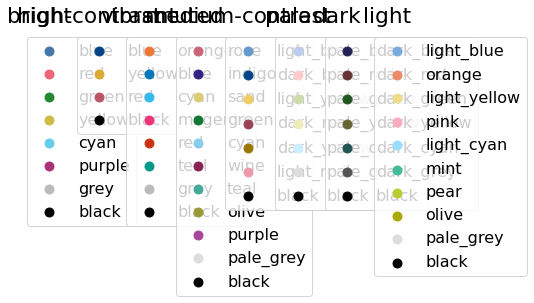

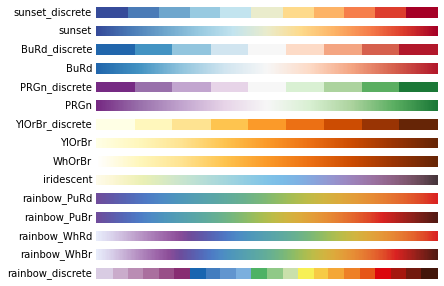

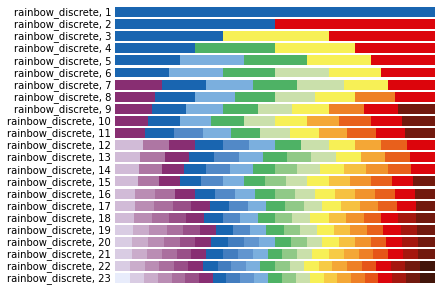

(array([12., 16., 20.,  5.,  7., 11., 11., 10.,  9.,  4.]),
 array([0.19900931, 0.4097306 , 0.62045187, 0.8311732 , 1.0418944 ,
        1.2526158 , 1.4633371 , 1.6740583 , 1.8847796 , 2.095501  ,
        2.3062222 ], dtype=float32),
 <BarContainer object of 10 artists>)

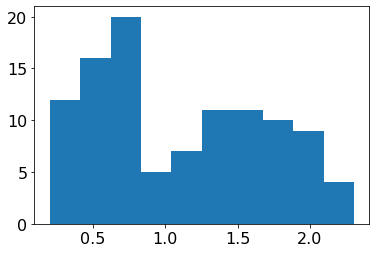

In [25]:
plt.hist(xsaf['Z_Spec'])

In [52]:
from sklearn.linear_model import LinearRegression
from astropy.cosmology import z_at_value

42
[[0.24104232]]
43
[[-0.00958615]]
9
[[0.03155073]]


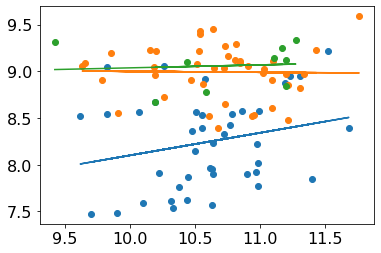

In [53]:
interval=1
bins=np.arange(0,2.5,interval)

for z in bins:
    mask=[False for i in range(len(xsaf))]
    for i in range(len(xsaf)):
        if z<xsaf['Z_Spec'][i]<z+interval:
            mask[i]=True
    print(sum(mask))
    x=np.log10(xsaf['bayes.stellar.m_star'][mask])
    y=xsaf['logMbh_best'][mask]
    w=xsaf['logMbh_err'][mask]
    X, Y = x.reshape(-1,1), y.reshape(-1,1)
    print(LinearRegression().fit(X, Y).coef_)
    plt.scatter(x,y)
    plt.plot(X, LinearRegression().fit(X, Y).predict(X) )

In [54]:
from itertools import cycle, tee

def pairwise(seq):
    a, b = tee(seq)
    next(b)
    return zip(a, b)

#interval=5*u.Gyr
#cosmo.age(interval)
#bins=[]
#bins=np.arange(0,2.5,interval)

end=2.5
age=cosmo.age(end)
interval=2.3*u.Gyr

bins_time=np.array([])
while age.value<cosmo.age(0).value:
    bins_time=np.append(z_at_value(cosmo.age,age),bins_time)
    age+=interval
bins_time[0]=0
bins_time[-1]=2.5

rat=np.array([])
rat_err=np.array([])
z_mean=np.array([])
for z, next_z in pairwise(cycle(bins_time)):
    if next_z==0:
        break
    z_mean=np.append(np.mean([z,next_z]),z_mean)
    mask=[False for i in range(len(xsaf))]
    for i in range(len(xsaf)):
        if z<xsaf['Z_Spec'][i]<next_z:
            mask[i]=True
    x=np.log10(xsaf['bayes.stellar.m_star'][mask])
    y=xsaf['logMbh_best'][mask]
    w=1/xsaf['logMbh_err'][mask]
    X, Y = x.reshape(-1,1), y.reshape(-1,1)
    p, cov = np.polyfit(x, y, 1, w=w,cov = True)
    errorbars = np.sqrt(np.diag(cov))[0]
    print(np.mean([z,next_z]),sum(mask),p[0],errorbars)
    #print(p[0])
    #plt.scatter(x,y)
    #plt.plot(x,p[0]*x+p[1])
    rat=np.append(p[0],rat)
    rat_err=np.append(errorbars,rat_err)
#plt.plot(np.arange(9,12,0.5),np.arange(9,12,0.5)-3.3)
plt.errorbar(z_mean,rat,yerr=rat_err)
plt.xlim([0,2.5])

<ipython-input-54-ac7fcc67479e>:37: RuntimeWarning: divide by zero encountered in true_divide
  w=1/xsaf['logMbh_err'][mask]
/home/ivan/Softwares/miniconda3/envs/astroutils/lib/python3.8/site-packages/numpy/lib/polynomial.py:628: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale


LinAlgError: SVD did not converge in Linear Least Squares

: 

IndexError: boolean index did not match indexed array along dimension 0; dimension is 278 but corresponding boolean dimension is 100

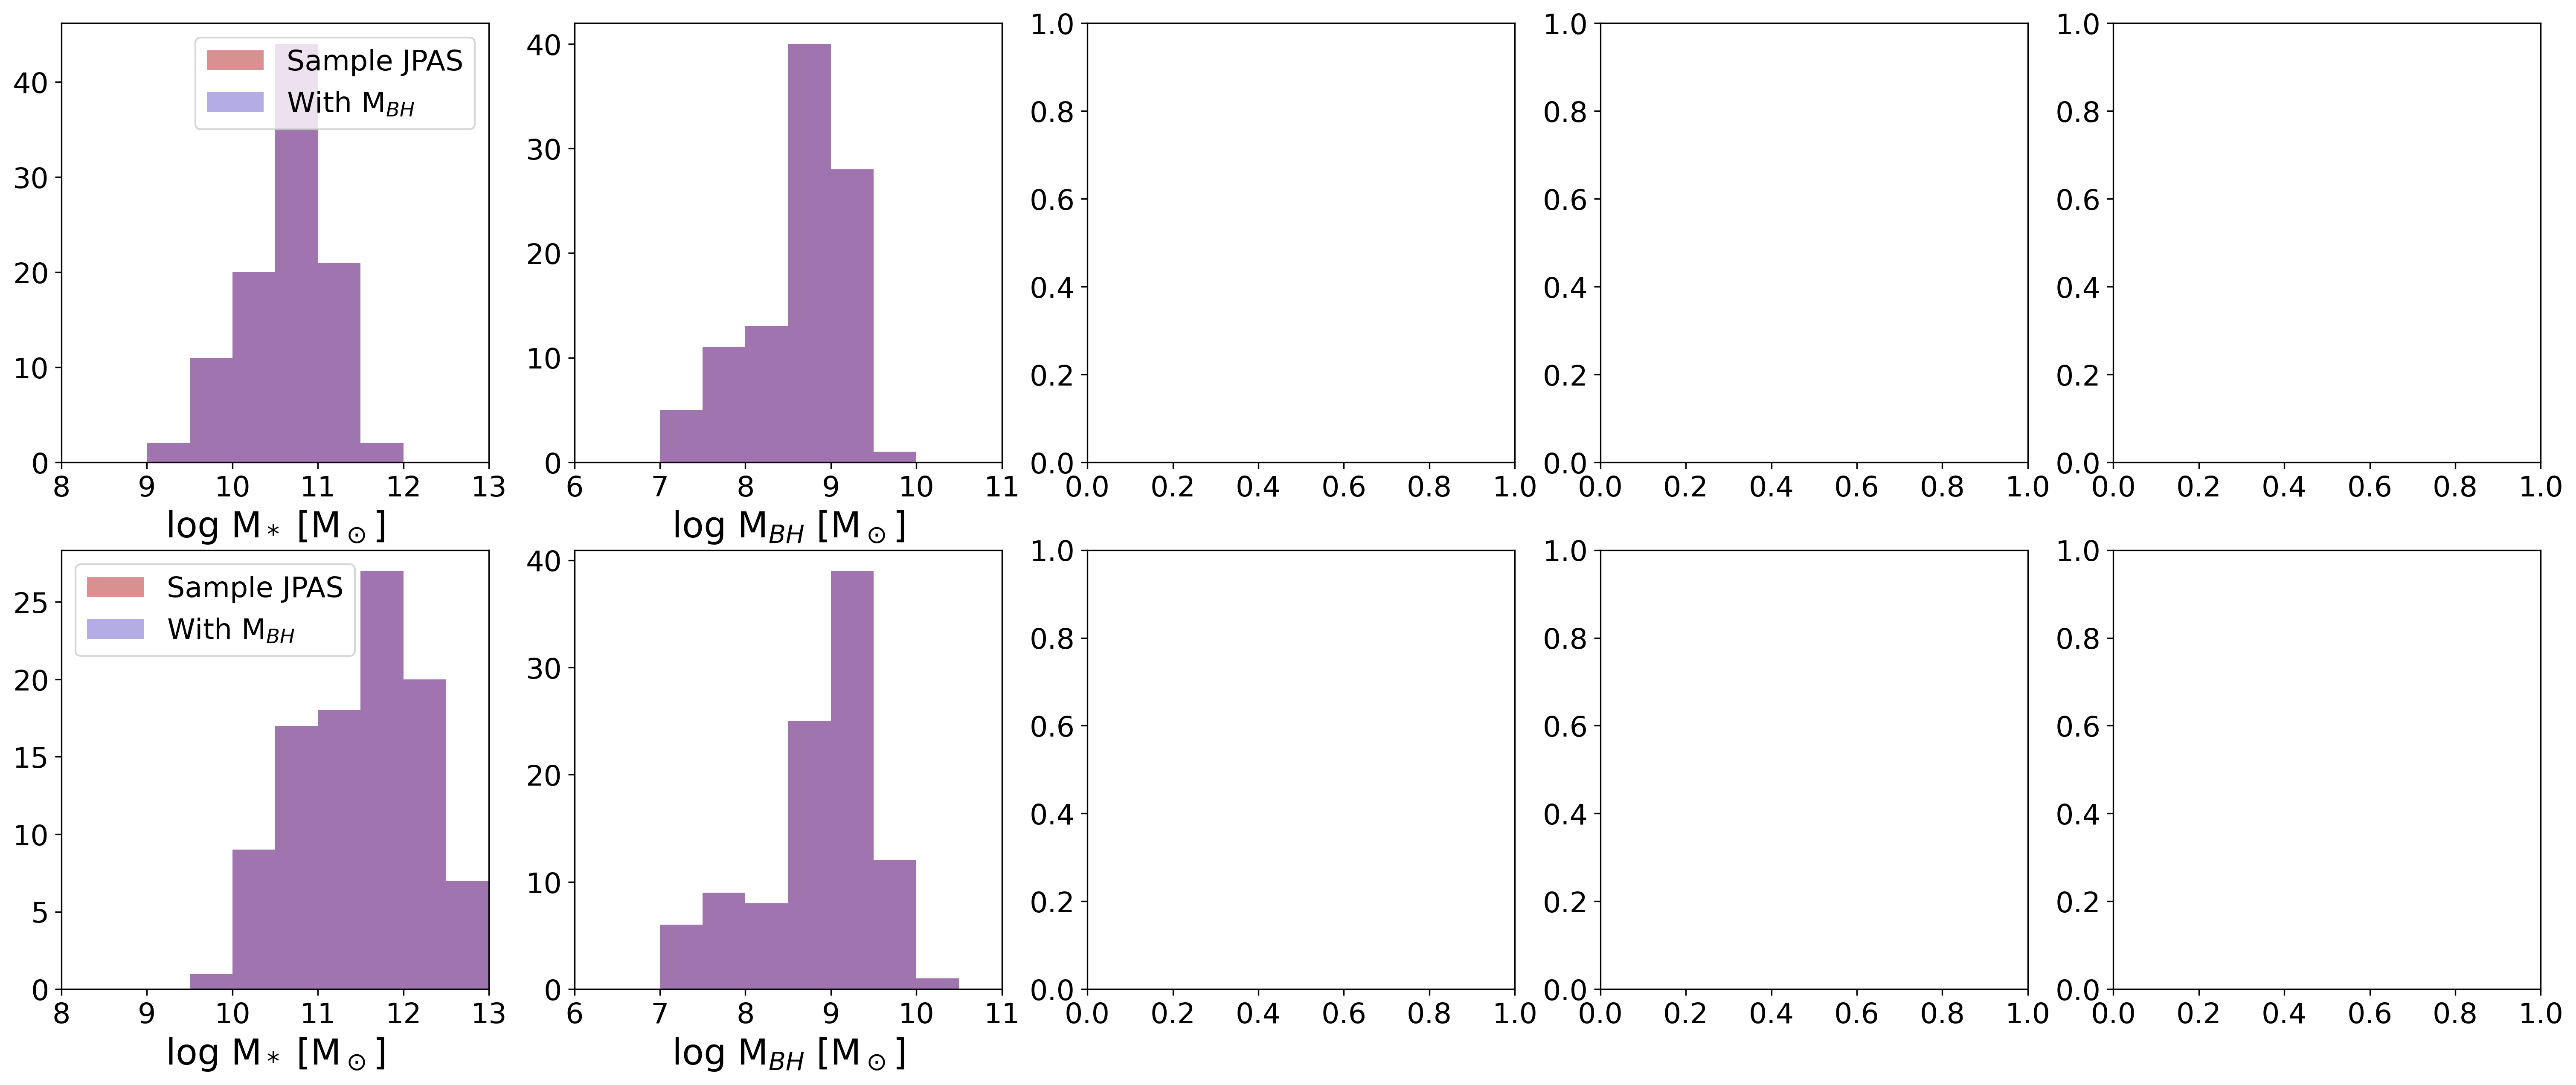

In [25]:
#sns.set_style("white")
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(25, 10), dpi=300)

#M*
ax = axs[0,0]
xmin,xmax=8,13
plot_x=np.log10(MST.value)
with_mbh=~np.isnan(MBH.value)
ax.hist(plot_x,bins=np.arange(xmin+1,xmax+1,0.5), color='firebrick', alpha=0.5, zorder=1, label='Sample JPAS')
ax.hist(plot_x[with_mbh],bins=np.arange(xmin+1,xmax+1,0.5), color='slateblue', alpha=0.5, zorder=1, label=r'With M$_{BH}$')
ax.legend()
ax.axis(xmin=xmin, xmax=xmax)
ax.set_xlabel(r'log M$_*$ [M$_\odot$]',size=20)
#######

#MBH
ax = axs[0,1]
plot_x=np.log10(MBH.value)
xmin,xmax=6,11
ax.hist(plot_x,bins=np.arange(xmin+1,xmax+1,0.5), color='firebrick', alpha=0.5, zorder=1, label=r'With M$_{BH}$')
ax.hist(plot_x[with_mbh],bins=np.arange(xmin+1,xmax+1,0.5), color='slateblue', alpha=0.5, zorder=1, label=r'With M$_{BH}$')
ax.axis(xmin=xmin, xmax=xmax)
ax.set_xlabel(r'log M$_{BH}$ [M$_\odot$]',size=20)
#######

#M*
ax = axs[1,0]
xmin,xmax=8,13
plot_x=np.log10(MST_md3.value)
with_mbh=~np.isnan(MST_md3.value)
ax.hist(plot_x,bins=np.arange(xmin+1,xmax+1,0.5), color='firebrick', alpha=0.5, zorder=1, label='Sample JPAS')
ax.hist(plot_x[with_mbh],bins=np.arange(xmin+1,xmax+1,0.5), color='slateblue', alpha=0.5, zorder=1, label=r'With M$_{BH}$')
ax.legend()
ax.axis(xmin=xmin, xmax=xmax)
ax.set_xlabel(r'log M$_*$ [M$_\odot$]',size=20)
#######

#MBH
ax = axs[1,1]
plot_x=np.log10(MBH_md3.value)
xmin,xmax=6,11
ax.hist(plot_x,bins=np.arange(xmin+1,xmax+1,0.5), color='firebrick', alpha=0.5, zorder=1, label=r'With M$_{BH}$')
ax.hist(plot_x[with_mbh],bins=np.arange(xmin+1,xmax+1,0.5), color='slateblue', alpha=0.5, zorder=1, label=r'With M$_{BH}$')
ax.axis(xmin=xmin, xmax=xmax)
ax.set_xlabel(r'log M$_{BH}$ [M$_\odot$]',size=20)
#######

#ENsSFR
ax = axs[0,2]
plot_x=ENSSFR[with_mbh]
xmin,xmax=-6,3
ax.hist(plot_x,bins=np.arange(xmin+1,xmax+1,0.5), color='firebrick', alpha=0.5, zorder=1, label='JPAS-Sample')
ax.hist(plot_x[with_mbh],bins=np.arange(xmin+1,xmax+1,0.5), color='slateblue', alpha=0.5, zorder=1, label=r'With M$_{BH}$')
ax.vlines(-1.2,0,55,colors='grey',linestyles='dotted')
ax.annotate('Quiescent', xy=(-3.8, 50), fontsize=14)
ax.annotate('Star-forming', xy=(-1, 50), fontsize=14)
ax.axis(xmin=xmin, xmax=xmax)
ax.set_xlabel(r'log ENsSFR [1/yr]',size=20)
#######

#ENsSFR
ax = axs[1,2]
plot_x=enssfr
xmin,xmax=-6,3
ax.hist(plot_x,bins=np.arange(xmin+1,xmax+1,0.5), color='firebrick', alpha=0.5, zorder=1, label='JPAS-Sample')
ax.hist(plot_x[with_mbh],bins=np.arange(xmin+1,xmax+1,0.5), color='slateblue', alpha=0.5, zorder=1, label=r'With M$_{BH}$')
ax.vlines(-1.2,0,55,colors='grey',linestyles='dotted')
ax.annotate('Quiescent', xy=(-3.8, 50), fontsize=14)
ax.annotate('Star-forming', xy=(-1, 50), fontsize=14)
ax.axis(xmin=xmin, xmax=xmax)
ax.set_xlabel(r'log ENsSFR [1/yr]',size=20)
#######

#MBHdot
ax = axs[0,3]
plot_x=np.log10(BHAR.value)
xmin,xmax=-4,4
ax.hist(plot_x,bins=np.arange(xmin+1,xmax+1,0.5), color='firebrick', alpha=0.5, zorder=1, label='JPAS-Sample')
ax.hist(plot_x[with_mbh],bins=np.arange(xmin+1,xmax+1,0.5), color='slateblue', alpha=0.5, zorder=1, label=r'With M$_{BH}$')
ax.axis(xmin=xmin, xmax=xmax)
ax.set_xlabel(r'log $\dot{M}_{BH}$ [M$_\odot$/yr]',size=20)
#######

#Edd
ax = axs[0,4]
plot_x=np.log10(EDD)
xmin,xmax=-4,2
ax.hist(plot_x,bins=np.arange(xmin+1,xmax+1,0.5), color='firebrick', alpha=0.5, zorder=1, label='JPAS-Sample')
ax.hist(plot_x[with_mbh],bins=np.arange(xmin+1,xmax+1,0.5), color='slateblue', alpha=0.5, zorder=1, label='JPAS-Sample')
ax.axis(xmin=xmin, xmax=xmax)
ax.set_xlabel(r'log $\lambda_{Edd}$',size=20)
#######

#MBHdot
ax = axs[1,3]
plot_x=np.log10(BHAR.value)
xmin,xmax=-4,4
ax.hist(plot_x,bins=np.arange(xmin+1,xmax+1,0.5), color='firebrick', alpha=0.5, zorder=1, label='JPAS-Sample')
ax.hist(plot_x[with_mbh],bins=np.arange(xmin+1,xmax+1,0.5), color='slateblue', alpha=0.5, zorder=1, label=r'With M$_{BH}$')
ax.axis(xmin=xmin, xmax=xmax)
ax.set_xlabel(r'log $\dot{M}_{BH}$ [M$_\odot$/yr]',size=20)
#######

#Edd
ax = axs[1,4]
plot_x=np.log10(EDD)
xmin,xmax=-4,2
ax.hist(plot_x,bins=np.arange(xmin+1,xmax+1,0.5), color='firebrick', alpha=0.5, zorder=1, label='JPAS-Sample')
ax.hist(plot_x[with_mbh],bins=np.arange(xmin+1,xmax+1,0.5), color='slateblue', alpha=0.5, zorder=1, label='JPAS-Sample')
ax.axis(xmin=xmin, xmax=xmax)
ax.set_xlabel(r'log $\lambda_{Edd}$',size=20)
#######

plt.savefig(path_fig+'Hist_z0.png', dpi=300, transparent=False, bbox_inches='tight')

In [ ]:
def mhalo_at_r(Mhalo_total,r,z):
    #Use NFW profile to obtain Mhalo at given radius
    ##To obtain profile's parameters 
    #Critic density of the Universe at z
    p200=(3*cosmo.H(z)**2/(8*np.pi*const.G)).to(u.kg/u.m**3)
    #r200=r_vir
    r200=((3*Mhalo_total/(4*np.pi*p200))**(1/3)).to(u.kpc)
    #Concentration from c-Mh relation Duffy+08
    Mpivot=2e12*u.Msun
    alpha,beta,gamma=5.71,-0.084,-0.47
    c200=alpha*(Mhalo_total/Mpivot)**beta*(1+z)**gamma
    ##Profile
    rs=r200/c200
    ps=Mhalo_total/(4*np.pi*rs**3*(np.log(1+c200)-(c200/(1+c200))))
    Mhr=4*np.pi*ps*rs**3*(np.log(1+r/rs)-(r/(rs+r)))
    return Mhr

masita_estre=1e11*u.Msun
zeta=1

masita_halo=Mste_to_Mhalo(zeta,masita_estre)
radiu_galax=mst_to_radius(1,masita_estre.value)

NFW=mhalo_at_r(masita_halo,radiu_galax,zeta)

def mhalo_at_r(Mhalo_total,r,z):
    #Use NFW profile to obtain Mhalo at given radius
    ##To obtain profile's parameters 
    #Critic density of the Universe at z
    p200=(3*cosmo.H(z)**2/(8*np.pi*const.G)).to(u.kg/u.m**3)
    #r200=r_vir
    r200=((3*Mhalo_total/(4*np.pi*p200))**(1/3)).to(u.kpc)
    #Concentration from c-Mh relation Duffy+08
    Mpivot=2e12*u.Msun
    alpha,beta,gamma=5.71,-0.084,-0.47
    c200=alpha*(Mhalo_total/Mpivot)**beta*(1+z)**gamma
    ##Profile
    rs=r200/c200
    ps=Mhalo_total/(4*np.pi*2/3*rs**3*(np.log(c200**(3/2)+1)))
    Mhr=4*np.pi*ps*2/3*rs**3*(np.log((r/rs)**(3/2)+1))
    return Mhr

Moore=mhalo_at_r(masita_halo,radiu_galax,zeta)

def mhalo_at_r(Mhalo_total,r,z):
    #Use NFW profile to obtain Mhalo at given radius
    ##To obtain profile's parameters 
    #Critic density of the Universe at z
    p200=(3*cosmo.H(z)**2/(8*np.pi*const.G)).to(u.kg/u.m**3)
    #r200=r_vir
    r200=((3*Mhalo_total/(4*np.pi*p200))**(1/3)).to(u.kpc)
    #Concentration from c-Mh relation Duffy+08
    Mpivot=2e12*u.Msun
    alpha,beta,gamma=5.71,-0.084,-0.47
    c200=alpha*(Mhalo_total/Mpivot)**beta*(1+z)**gamma
    ##Profile
    rs=r200/c200
    ps=Mhalo_total/(4*np.pi*rs**3*(r200/(rs+r200)))
    Mhr=4*np.pi*ps*rs**3*(r/(r+rs))
    return Mhr

Jaffe=mhalo_at_r(masita_halo,radiu_galax,zeta)

def mhalo_at_r(Mhalo_total,r,z):
    #Use Isothermical profile to obtain Mhalo at given radius
    ##To obtain profile's parameters 
    #Critic density of the Universe at z
    p200=(3*cosmo.H(z)**2/(8*np.pi*const.G)).to(u.kg/u.m**3)
    #r200=r_vir
    r200=((3*Mhalo_total/(4*np.pi*p200))**(1/3)).to(u.kpc)
    #Concentration from c-Mh relation Duffy+08
    Mpivot=2e12*u.Msun
    alpha,beta,gamma=5.71,-0.084,-0.47
    c200=alpha*(Mhalo_total/Mpivot)**beta*(1+z)**gamma
    ##Profile
    rs=r200/c200
    ps=Mhalo_total/(4*np.pi*rs**3*(np.log(1+c200)))
    Mhr=4*np.pi*ps*rs**3*(np.log(1+r/rs))
    return Mhr

Iso=mhalo_at_r(masita_halo,radiu_galax,zeta)

print('NSW   Moore   Jaffe Iso')
print(np.log10(NFW.value).round(2),' ',np.log10(Moore.value).round(2),' ',np.log10(Jaffe.value).round(2),np.log10(Iso.value).round(2))

In [ ]:
masita_estre=1e10*u.Msun
zeta=1

masita_halo=Mste_to_Mhalo(zeta,masita_estre)
radiu_galax=mst_to_radius(0,masita_estre.value)
Mhr=mhalo_at_r(masita_halo,radiu_galax,zeta)